## Импорт библиотек

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np 
import pandas as pd
import torch
import re
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, f1_score, PrecisionRecallDisplay, precision_recall_curve, auc, average_precision_score, RocCurveDisplay
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from PIL import Image as Im

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import lightgbm as lgb
from lightgbm import LGBMClassifier
import optuna
from optuna.pruners import MedianPruner
import time, logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Если захотите прогнать этот ноутбук на Kaggle, то можно воспользоваться вот этой ячейкой:

In [ ]:
# import nltk
# import subprocess

# try:
#     nltk.data.find('wordnet.zip')
# except:
#     nltk.download('wordnet', download_dir='/kaggle/working/')
#     command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
#     subprocess.run(command.split())
#     nltk.data.path.append('/kaggle/working/')

# from nltk.corpus import wordnet

Если хотите прогнать ноутбук локально, то воспользуйтесь этой ячейкой:

In [ ]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt', download_dir='/Users/andreypetukhov/Documents/vk-internship-task')
nltk.download('wordnet', download_dir='/Users/andreypetukhov/Documents/vk-internship-task')
nltk.download('stopwords', download_dir='/Users/andreypetukhov/Documents/vk-internship-task')

## Загружаем данные

In [5]:
train = pd.read_csv('train_spam.csv')
test = pd.read_csv('test_spam.csv')

data = pd.concat((train, test)).fillna('-')

#посчитаю длину каждого предложения, чтобы посмотреть распределение длин в зависимости от таргета
train['length'] = train['text'].apply(lambda x: len(x.split()))

## Предварительный анализ

Посмотрим, насколько сбалансированные у нас данные - сколько всего спама и неспама:

In [5]:
sizes = train['text_type'].value_counts()
explode = (0, 0.1)

fig = plt.figure(figsize=(10, 6), facecolor='whitesmoke')

plt.pie(sizes, explode=explode, labels=['Ham', 'Spam'],
       autopct='%1.1f%%', shadow=True, startangle=90, colors=sns.color_palette('muted'))
plt.title('Баланс классов в выборке', weight='bold')

plt.show()

Как видим, в выборке есть дисбаланс классов, но он не критический - всего 70 на 30. Посмотрим теперь, насколько хорошо длина предложений помогает различать спам и не спам:

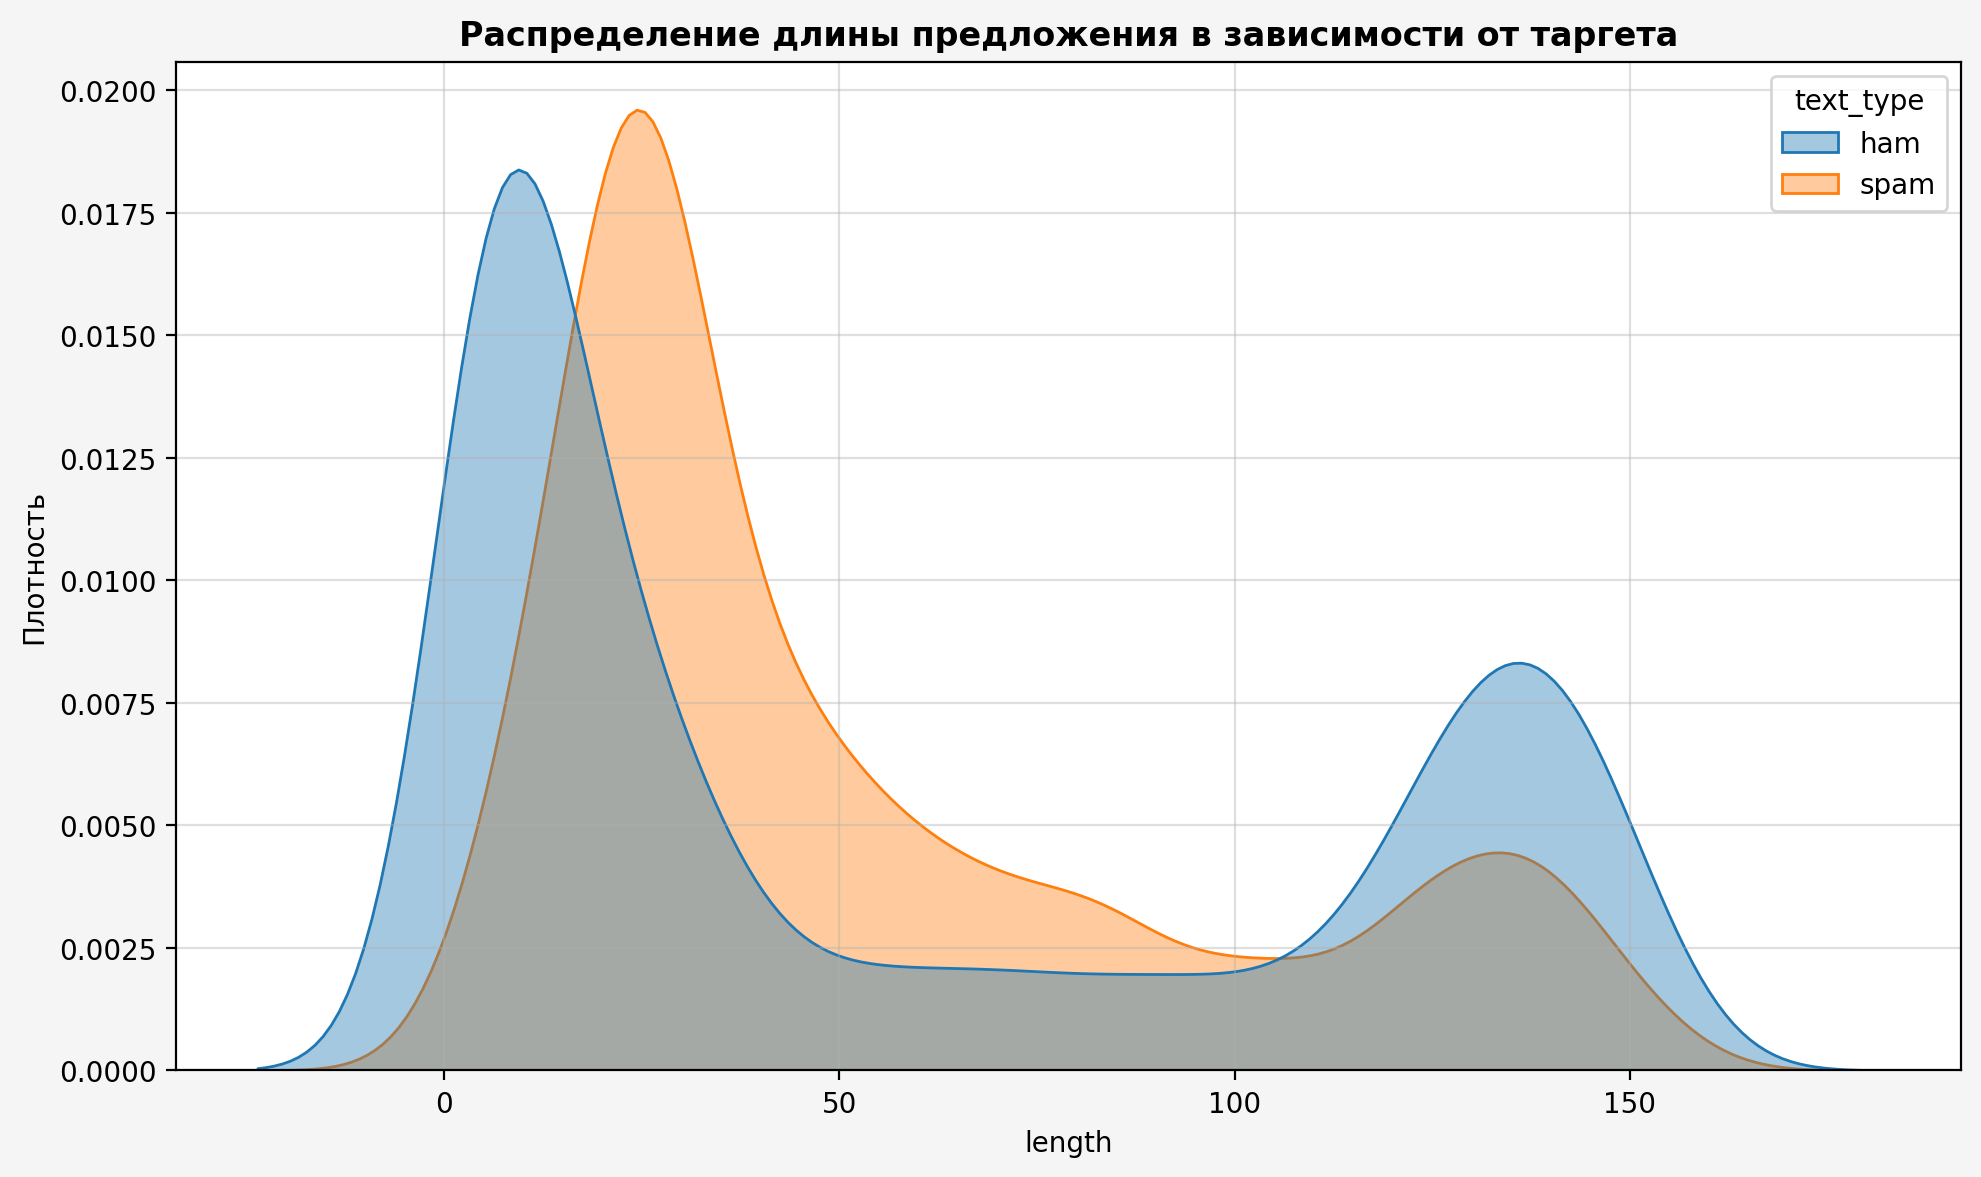

In [9]:
fig, ax = plt.subplots(figsize=(10, 6), facecolor='whitesmoke')

q_low, q_high = train['length'].quantile([0.01, 0.99])
filtered_data = train[(train['length'] >= q_low) & (train['length'] <= q_high)]

sns.kdeplot(data=filtered_data, x='length', ax=ax, hue='text_type', fill=True, common_norm=False, alpha=0.4)

ax.set_title(f"Распределение длины предложения в зависимости от таргета", weight='bold')

ax.set_ylabel('Плотность')
ax.set_xlabel('length')
ax.grid(alpha=0.4)

plt.tight_layout()

plt.show()

Распределения в целом выглядят довольно похожими, но распределение спамовых сообщений сдвинуто вправо отновительно левого, то есть сообщения с меткой "спам" обычно немного длиннее.

## Предобработка данных

В качестве предобработки очистим текст от стоп-слов, удалим из сообщений слова, не несущие смысловую нагрузку, переведём всё в нижний регистр и приведём к начальной форме, то есть лемматизируем тексты.

In [7]:
def preprocess(text, stop_words, lemmatizer = nltk.WordNetLemmatizer):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text])

    return text

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said', 'u'])
lemmatizer = nltk.WordNetLemmatizer()

train['target'] = (train['text_type'] == 'ham').astype(int)
train['clean_text'] = train['text'].apply(preprocess, stop_words=stop_words, lemmatizer=lemmatizer)
test['clean_text'] = test['text'].apply(preprocess, stop_words=stop_words, lemmatizer=lemmatizer)

texts, targets = train['clean_text'], train['target']

### Облака слов

Посмотрим на облака слов для спам и не спам текстов:

In [9]:
def draw_wordcloud(texts, mask_path=None, max_words=1000, width=1000, height=500):

    if mask_path is not None:
        mask_image = np.array(Im.open(mask_path))  # маска
    else:
        mask_image = None

    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height, mask=mask_image)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

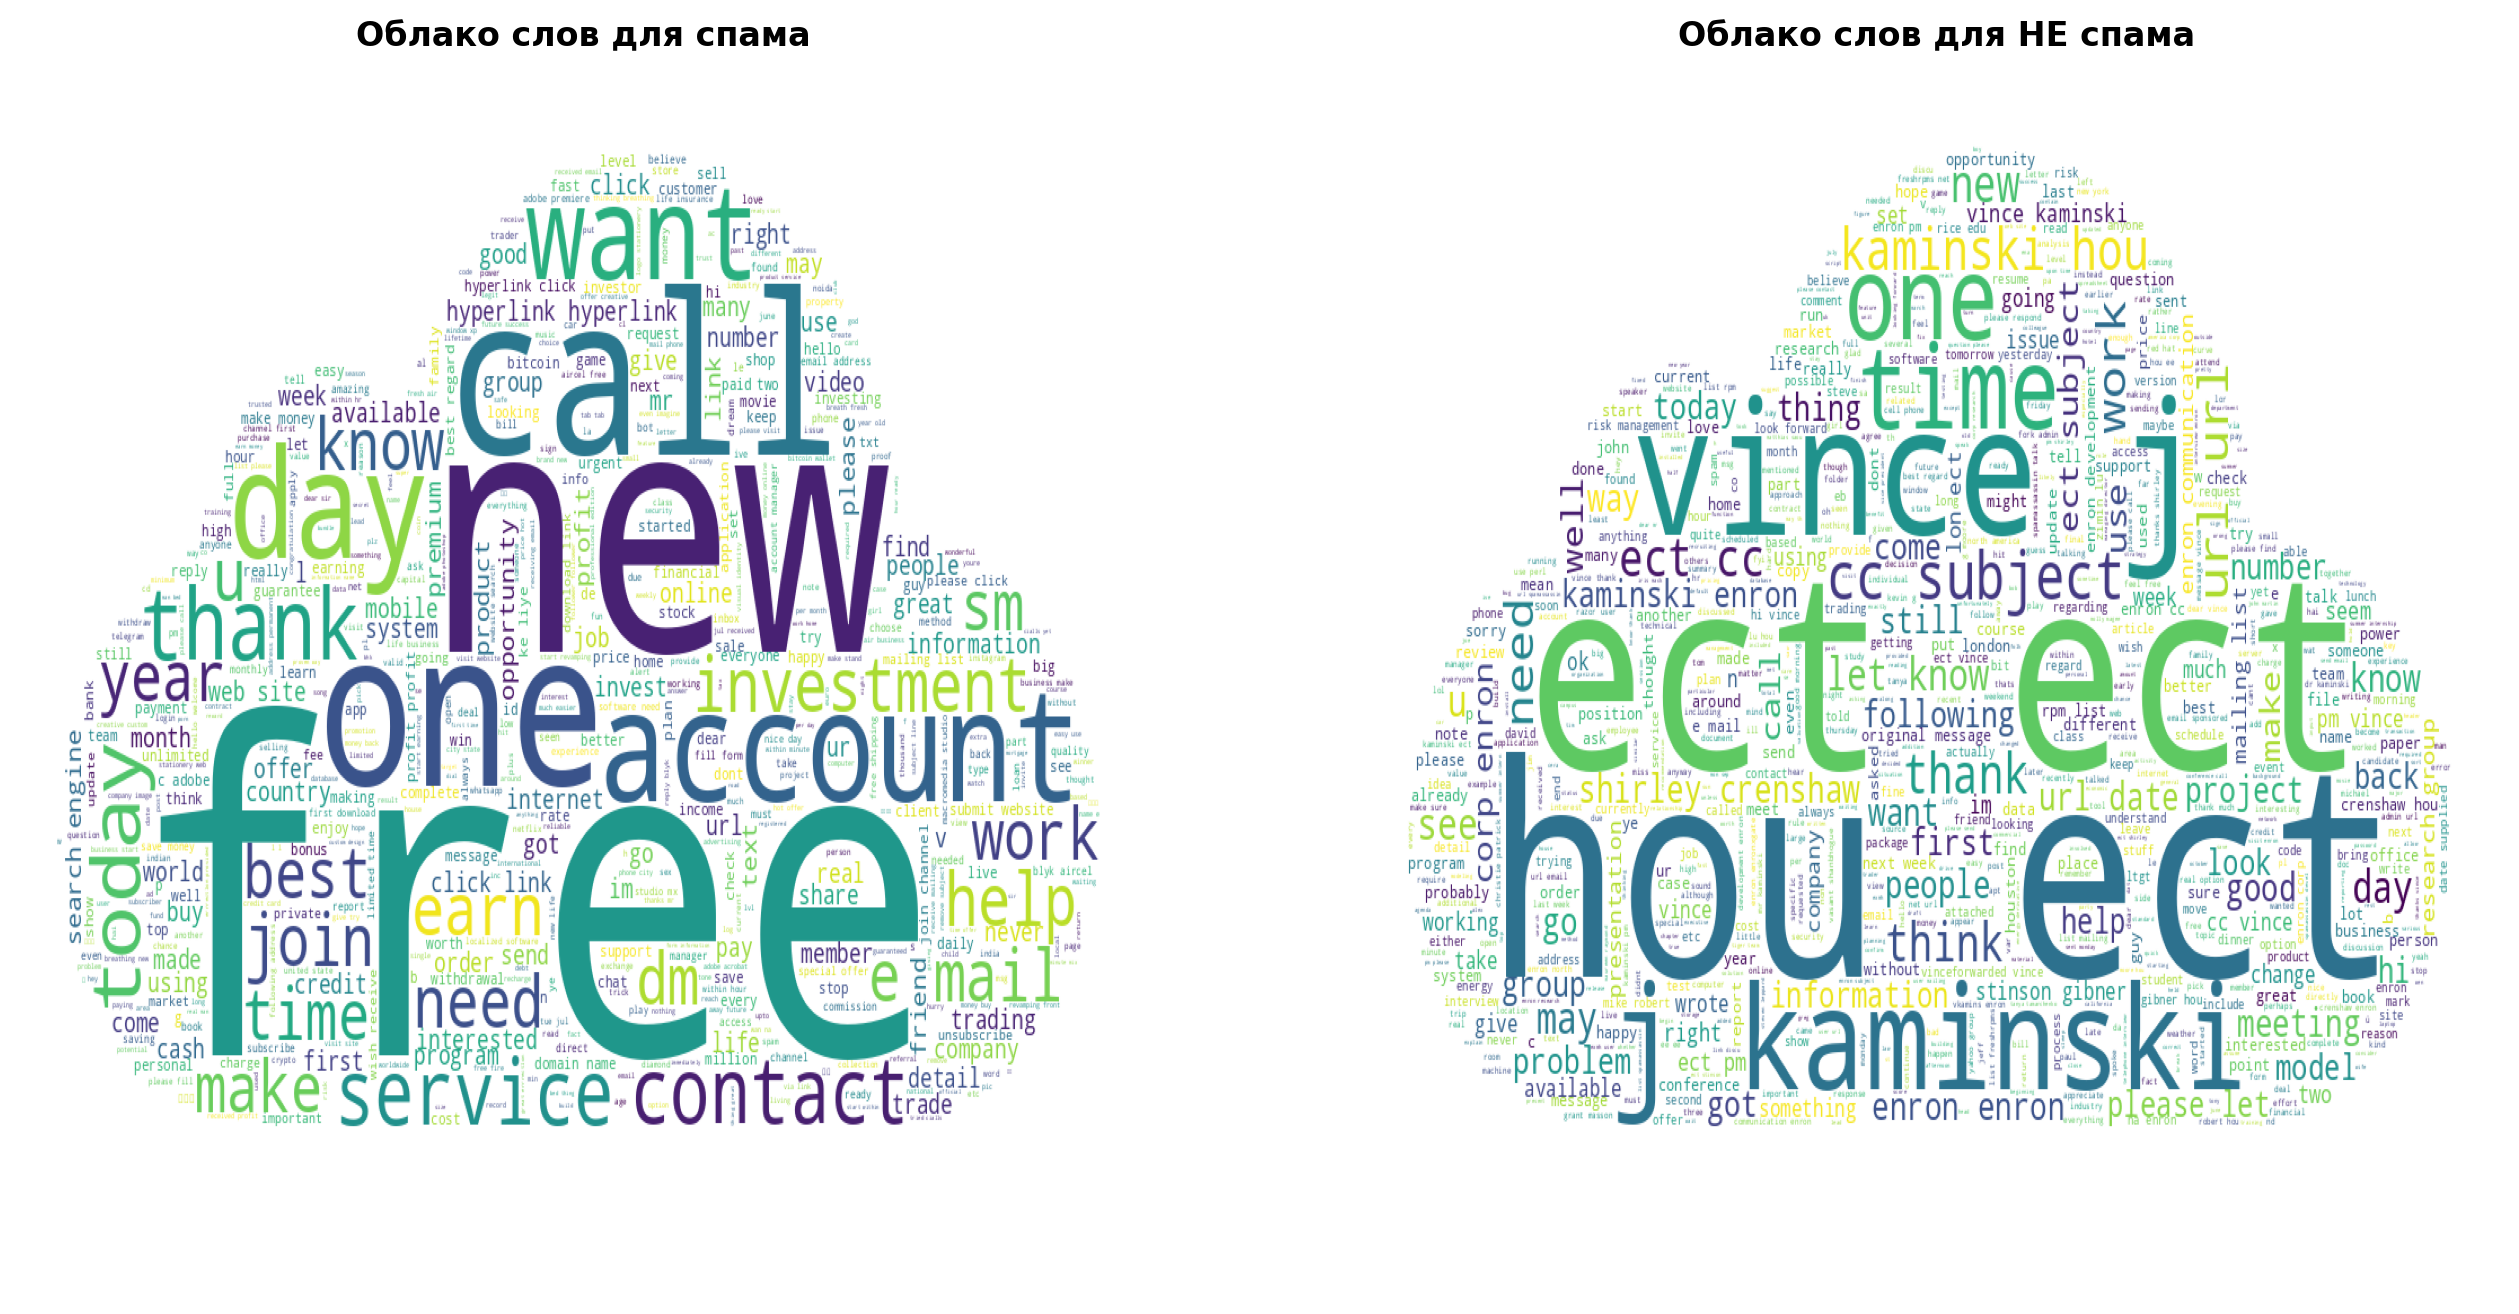

In [10]:
spam_mask = (train['text_type'] == 'spam')

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(draw_wordcloud(train[spam_mask]['clean_text'], mask_path='/kaggle/input/cloud-png/cloud.png'), aspect='auto')
ax[0].set_title('Облако слов для спама', weight='bold')
ax[0].axis('off')

ax[1].imshow(draw_wordcloud(train[~spam_mask]['clean_text'], mask_path='/kaggle/input/cloud-png/cloud.png'), aspect='auto')
ax[1].set_title('Облако слов для НЕ спама', weight='bold')
ax[1].axis('off')

plt.show()

Видим, что в спамерских сообщениях часто фигурируют такие слова как 'free', 'new', 'thank', 'call', 'account', что вообще очень ожидаемо! Причём в блоке спама есть прям крупные слова, выделяющиеся на фоне остальных, а в блоке нормальных сообщений таких нет.

### Кластеризация

Попробуем кластеризовать наши тексты по их TF-IDF представлениям и посмотреть на них с помощью TSNE. Количество кластеров возьмём побольеш, чем 2, чтобы иметь шансы на какое-то тематическое моделирование. Хотя ожидать, что все спамерские письма объединены общей темой и словами, не приходится, но вдруг удастся увидеть какие-то закономерности.

In [7]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import TSNE

#преобразуем в TF-IDF
vectorizer = TfidfVectorizer(encoding='utf8', min_df=0.0005, max_df=0.9)
train_tfidf = vectorizer.fit_transform(texts)

#кластеризауем тексты по TF-IDF представлениям
kmeans = KMeans(n_clusters = 5, n_init='auto')
kmeans_clusters = kmeans.fit_predict(train_tfidf)

spectral = SpectralClustering(n_clusters=5)
spectral_clusters = spectral.fit_predict(train_tfidf)

In [8]:
#понизим размерность с помощью TSNE
tsne = TSNE(n_jobs=2, perplexity=50, random_state=42)
X_tsne = tsne.fit_transform(train_tfidf.toarray())

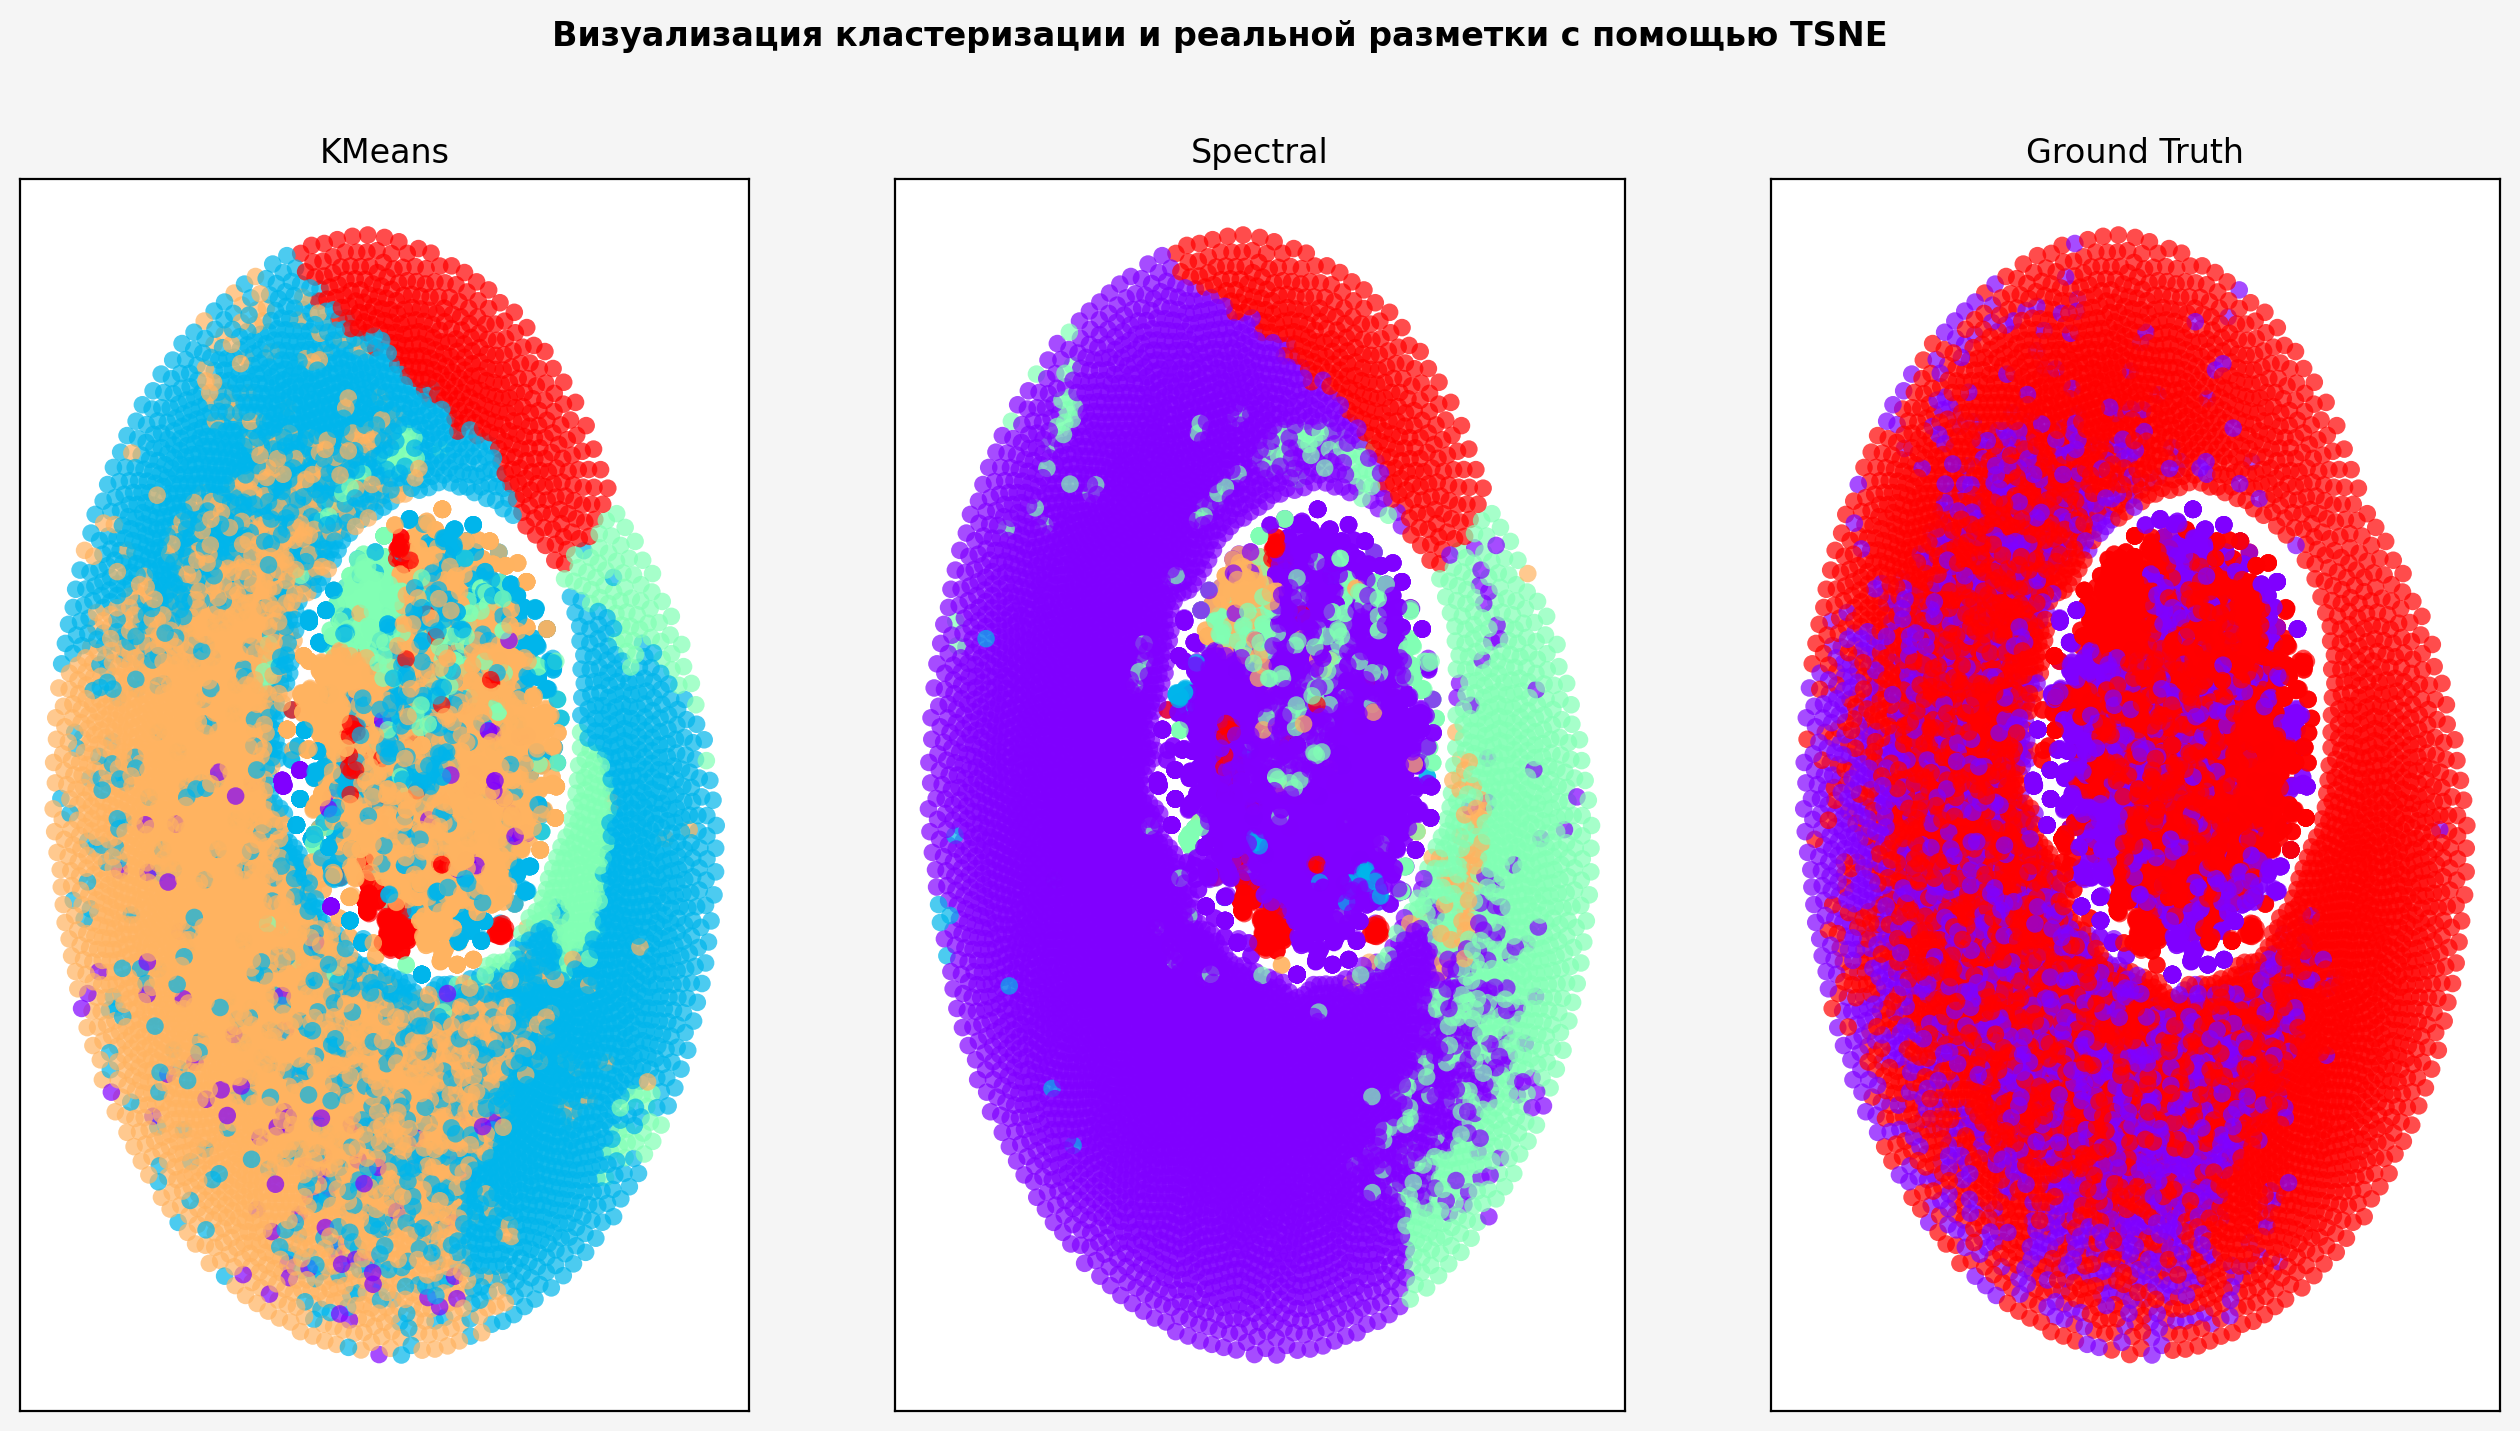

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8), facecolor='whitesmoke')
colormap = 'rainbow'

## KMeans
ax[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_clusters, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=mpl.colormaps[colormap])
ax[0].set_title('KMeans')
ax[0].set_xticks([])
ax[0].set_yticks([])

## Spectral
ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=spectral_clusters, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=mpl.colormaps[colormap])
ax[1].set_title('Spectral')
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=(targets == 1).astype(int), 
            edgecolor='none', alpha=0.7, s=40,
            cmap=mpl.colormaps[colormap])
ax[2].set_title('Ground Truth')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.suptitle('Визуализация кластеризации и реальной разметки с помощью TSNE', weight='bold')

plt.show()

## Модели

Попробуем выделить среди встречающихся сообщений какие-то конкретные темы. Попробуем следующие подходы:
- Логрег на TF-IDF признаках
- K-Means на TF-IDF признаках + логрег на расстояниях до центров кластеров
- Латентное размещение Дирихле (LDA) + Логрег на вероятностях тем
- NaiveBias на TF-IDF признаках
- Бустинг на TF-IDF признаках
- LSTM на GloVe эмбеддингах слов.

Для второго и третьего алгоритмов подберём оптимальное количество кластеров и тем соответственно, возможно пренебрегая интерпретируемостью полученных кластеров/тем, но нас всё-таки интересует качество. От последней модели ожидаем наилучшего качества.

### Логрег на TF-IDF признаках

Возьмём первую пришедшую в голову модель - логистическая регрессия на TF-IDF представлениях наших текстов. Переберём значения для гиперпараметра C и посмотрим на качество на кросс-валидации на 4-х фолдах.

In [ ]:
pipeline = Pipeline(
    [
        ('Vectorizer', TfidfVectorizer(encoding='utf8', max_df=0.9, min_df=0.0005)),
        ('LogReg', LogisticRegression(max_iter=10000))
    ]
)

param_grid = {'LogReg__C': np.logspace(-1, 2.7, 20)}

grid_search_1 = GridSearchCV(pipeline, param_grid, cv=4, scoring=make_scorer(roc_auc_score, needs_proba=True), verbose=3)
grid_search_1.fit(train['clean_text'], train['target'])

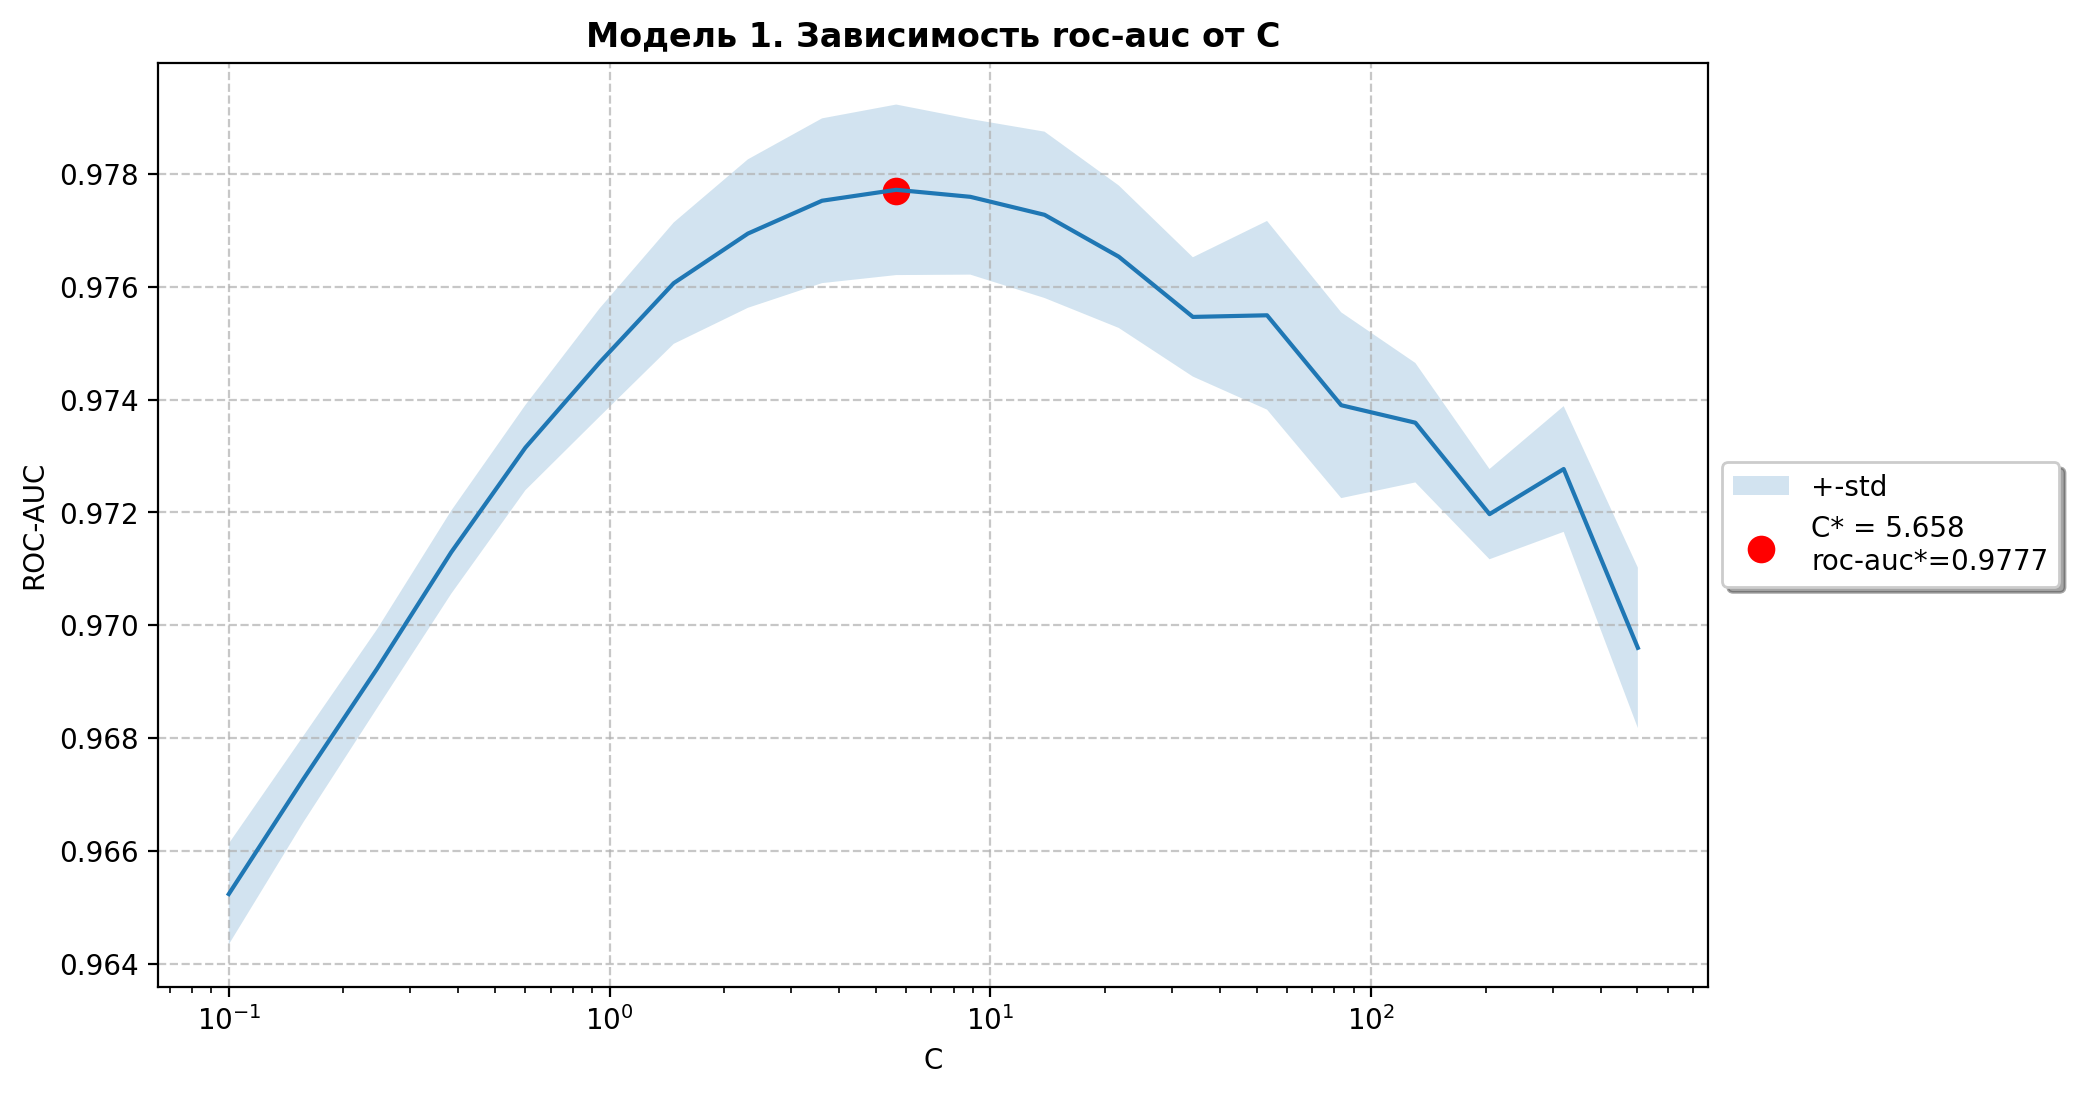

In [22]:
mean_roc_aucs = grid_search_1.cv_results_['mean_test_score']
stds = grid_search_1.cv_results_['std_test_score']

fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(np.logspace(-1, 2.7, 20), mean_roc_aucs)
plt.fill_between(np.logspace(-1, 2.7, 20), np.array(mean_roc_aucs) - np.array(stds), np.array(mean_roc_aucs) + np.array(stds), alpha=0.2, label='+-std')
ax.set_xscale('log')

argmax = np.logspace(-1, 2.7, 20)[np.argmax(mean_roc_aucs)].round(3)
max = np.max(mean_roc_aucs).round(4)

plt.scatter(argmax, max, color='red', s=80, label=f'C* = {argmax}\nroc-auc*={max}')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), frameon=True, shadow=True)
plt.xlabel('C')
plt.ylabel('ROC-AUC')
plt.grid(alpha=0.7, linestyle='--')
plt.title('Модель 1. Зависимость roc-auc от C', weight='bold')

plt.show()

Очень впечатляющие результаты от обычного логрега! Модель выдаёт отличное качество, почти 0.98 roc-auc при очень маленьком разбросе.

### KMeans на TF-IDF + Логрег

Теперь возьмём пайплайн, где мы на TF-IDF представлениях кластеризуем наши тексты с помощью KMeans, считаем расстояния до центроидов и классифицируем на основании этой информации наши тексты. 

Логика этого подхода в том, что при кластеризации наши тексты разделятся на темы и тексты рекламы каких-нибудь услуг будут отнесены к спаму (условно). Будем перебирать число кластеров, не заботясь об интерпретируемости - здесь нас интересует качество.

In [ ]:
pipeline = Pipeline(
        [
        ('TF-IDF', TfidfVectorizer(encoding='utf8', min_df=0.0005, max_df=0.9)),
        ('KMeans', KMeans()),
        ('Scaler', StandardScaler()),
        ('LogisticRegression', LogisticRegression(max_iter=10000))
        ]
    )

param_grid = {
    'KMeans__n_clusters': np.arange(20, 1020, 50)
}

grid_search_2 = GridSearchCV(pipeline, param_grid, cv=4, scoring=make_scorer(roc_auc_score, needs_proba=True), verbose=3)
grid_search_2.fit(train['clean_text'], train['target'])

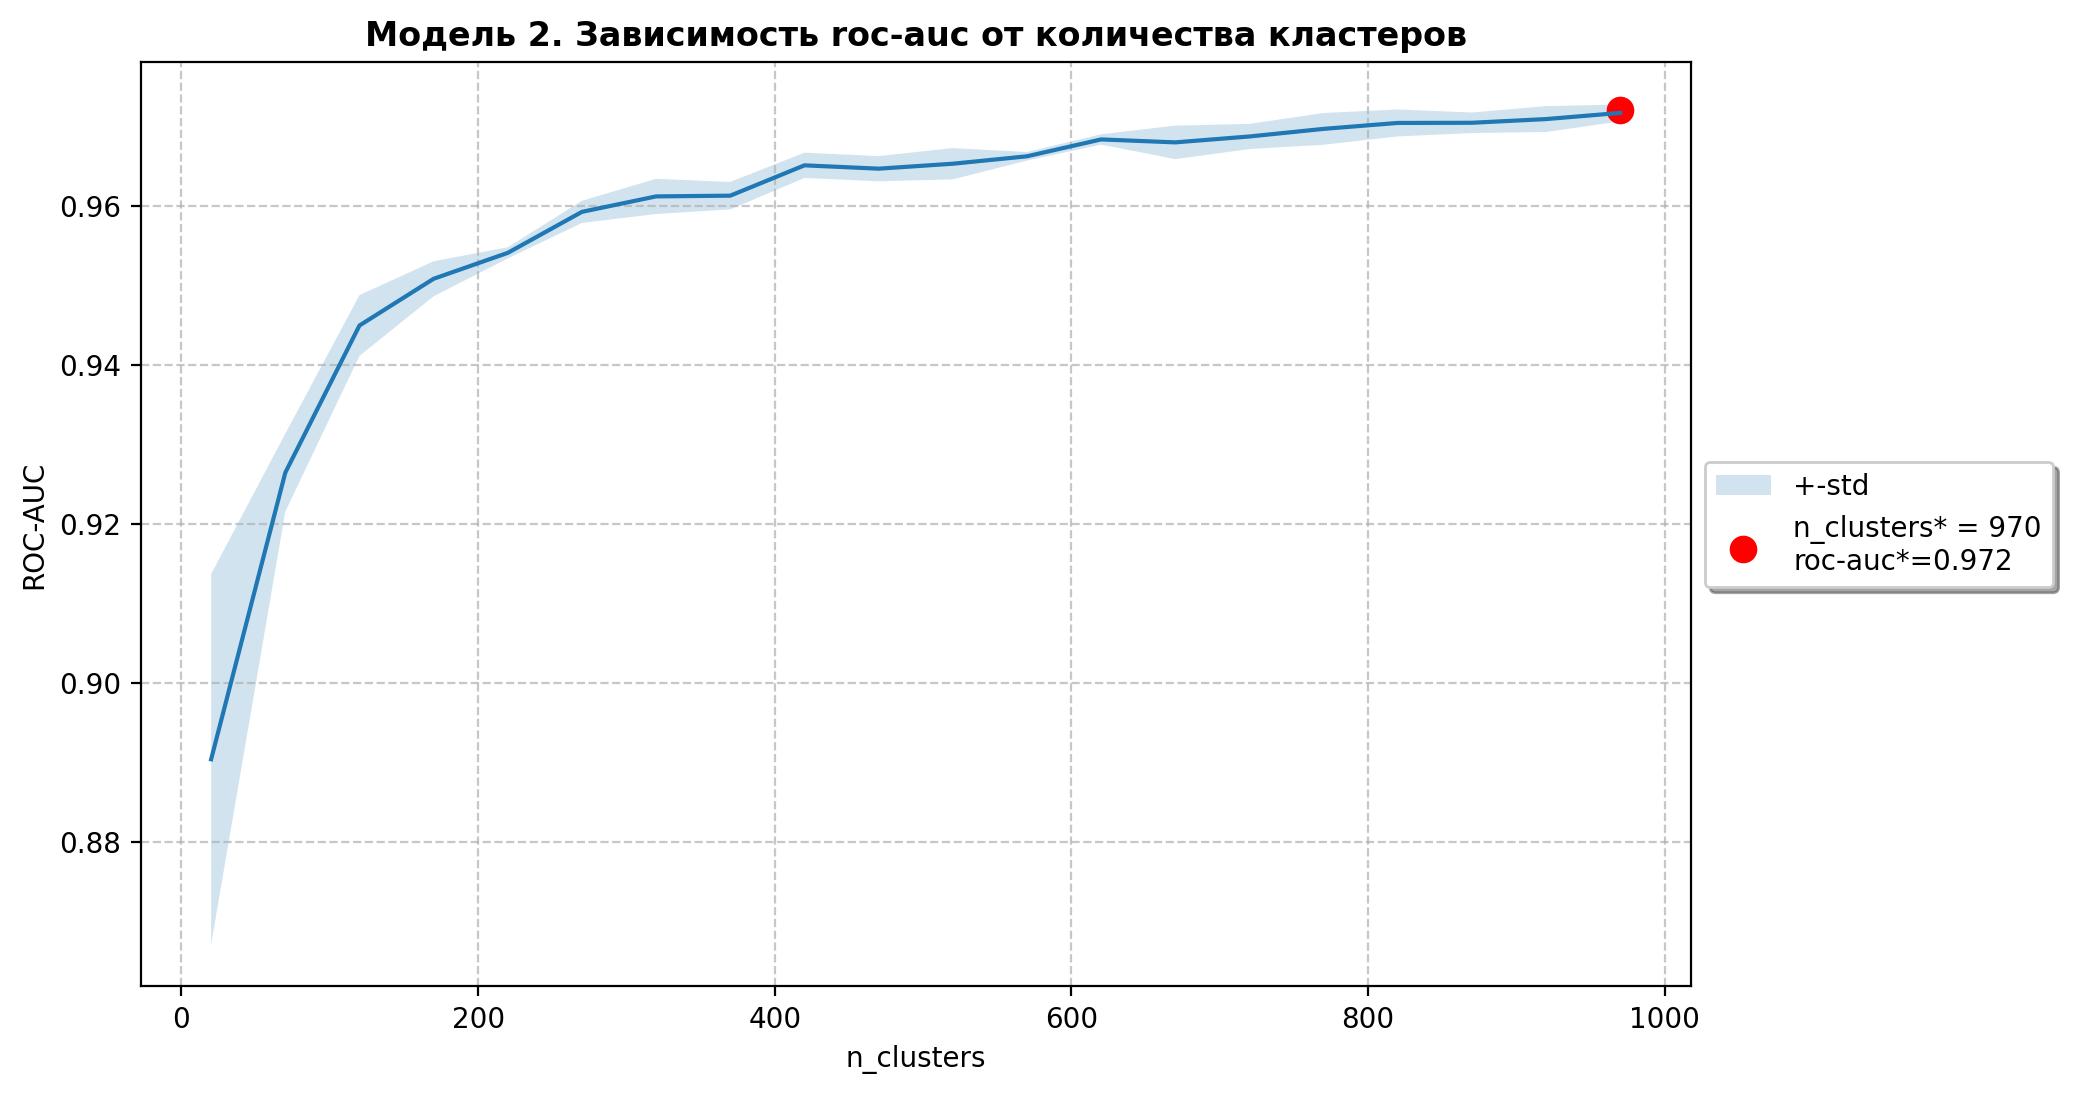

In [9]:
mean_roc_aucs = grid_search_2.cv_results_['mean_test_score']
stds = grid_search_2.cv_results_['std_test_score']

fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(np.arange(20, 1020, 50), mean_roc_aucs)
plt.fill_between(np.arange(20, 1020, 50), np.array(mean_roc_aucs) - np.array(stds), np.array(mean_roc_aucs) + np.array(stds), alpha=0.2, label='+-std')

argmax = np.arange(20, 1020, 50)[np.argmax(mean_roc_aucs)]
max = np.max(mean_roc_aucs).round(3)

plt.scatter(argmax, max, color='red', s=80, label=f'n_clusters* = {argmax}\nroc-auc*={max}')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), frameon=True, shadow=True)
plt.xlabel('n_clusters')
plt.ylabel('ROC-AUC')
plt.grid(alpha=0.7, linestyle='--')
plt.title('Модель 2. Зависимость roc-auc от количества кластеров', weight='bold')

plt.show()

KMeans подавала надежды, но дальнейшее исследование показало, что примерно после 1000 кластеров модель выходит на плато. Результаты тут ниже, чем у логрега. Отмечу, что именно наличие скейлера обеспечивает такую низкую дисперсию - без него модель сильно колбасит.

### LDA + логрег на вероятностях тем

Ещё один подход, связанный с определением тем текстов. Здесь мы преобразуем тексты с помощью Латентного размещения Дирихле и на полученных вероятностях тем попробуем классифицировать наши тексты. Диапазон для количества тем здесь берём существенно поменьше, чем в случае с KMeans.

In [ ]:
pipeline = Pipeline([
    ('Vectorizer', CountVectorizer()),
    ('LDA', LatentDirichletAllocation()),
    ('LogReg', LogisticRegression(max_iter=1000))
])

param_grid = {
    'LDA__n_components': np.arange(6, 18)
}

grid_search_3 = GridSearchCV(pipeline, param_grid, cv=4, scoring=make_scorer(roc_auc_score, needs_proba=True), verbose=4)
grid_search_3.fit(train['clean_text'], train['target'])

Посмотрим на результаты:

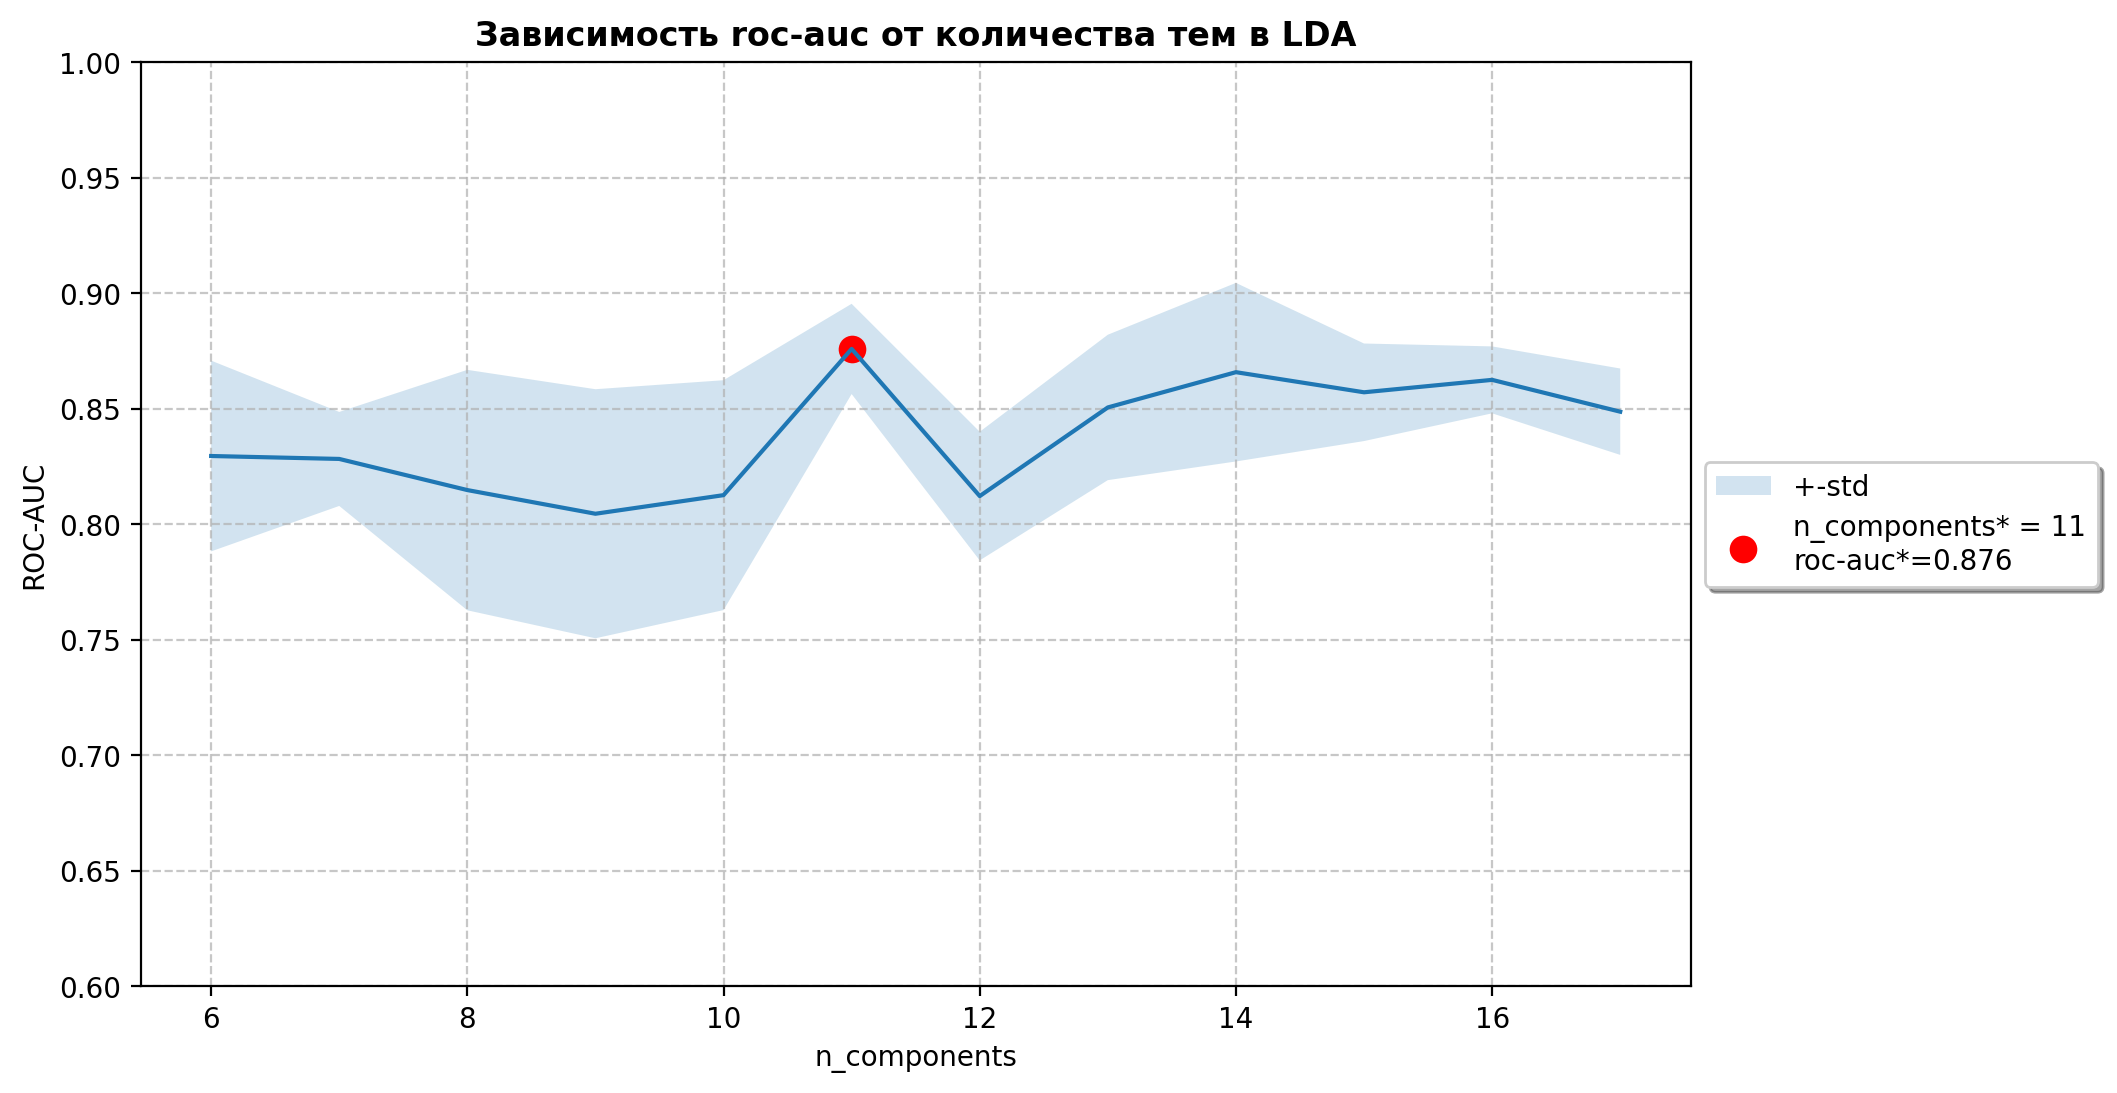

In [13]:
mean_roc_aucs = grid_search_3.cv_results_['mean_test_score']
stds = grid_search_3.cv_results_['std_test_score']

fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(np.arange(6, 18), mean_roc_aucs)
plt.fill_between(np.arange(6, 18), np.array(mean_roc_aucs) - np.array(stds), np.array(mean_roc_aucs) + np.array(stds), alpha=0.2, label='+-std')

argmax = np.arange(6, 18)[np.argmax(mean_roc_aucs)]
max = np.max(mean_roc_aucs).round(3)

plt.scatter(argmax, max, color='red', s=80, label=f'n_components* = {argmax}\nroc-auc*={max}')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), frameon=True, shadow=True)
plt.xlabel('n_components')
plt.ylabel('ROC-AUC')
plt.ylim(0.6, 1)
plt.grid(alpha=0.7, linestyle='--')
plt.title('Зависимость roc-auc от количества тем в LDA', weight='bold')

plt.show()

Результаты не впечатляют, пока что это самая слабая модель.

### Multinomial Naive Bayes

Теперь попробуем наивный байесовский классификатор для дискретных признаков. В документации sklearn сказано, что на tf-idf также можно его запускать, несмотря на то, что признаки не дискретные, так что этот подход тоже проверим.

In [ ]:
pipeline = Pipeline([
    ('Vectorizer', TfidfVectorizer(encoding='utf8', max_df=0.9, min_df=0.0005)),
    ('Classifier', MultinomialNB()) 
])

param_grid = {'Classifier__alpha': np.linspace(0.0001, 1, 20)}
grid_search_4 = GridSearchCV(pipeline, param_grid, cv=4, scoring=make_scorer(roc_auc_score, needs_proba=True), verbose=3)
grid_search_4.fit(texts, targets)

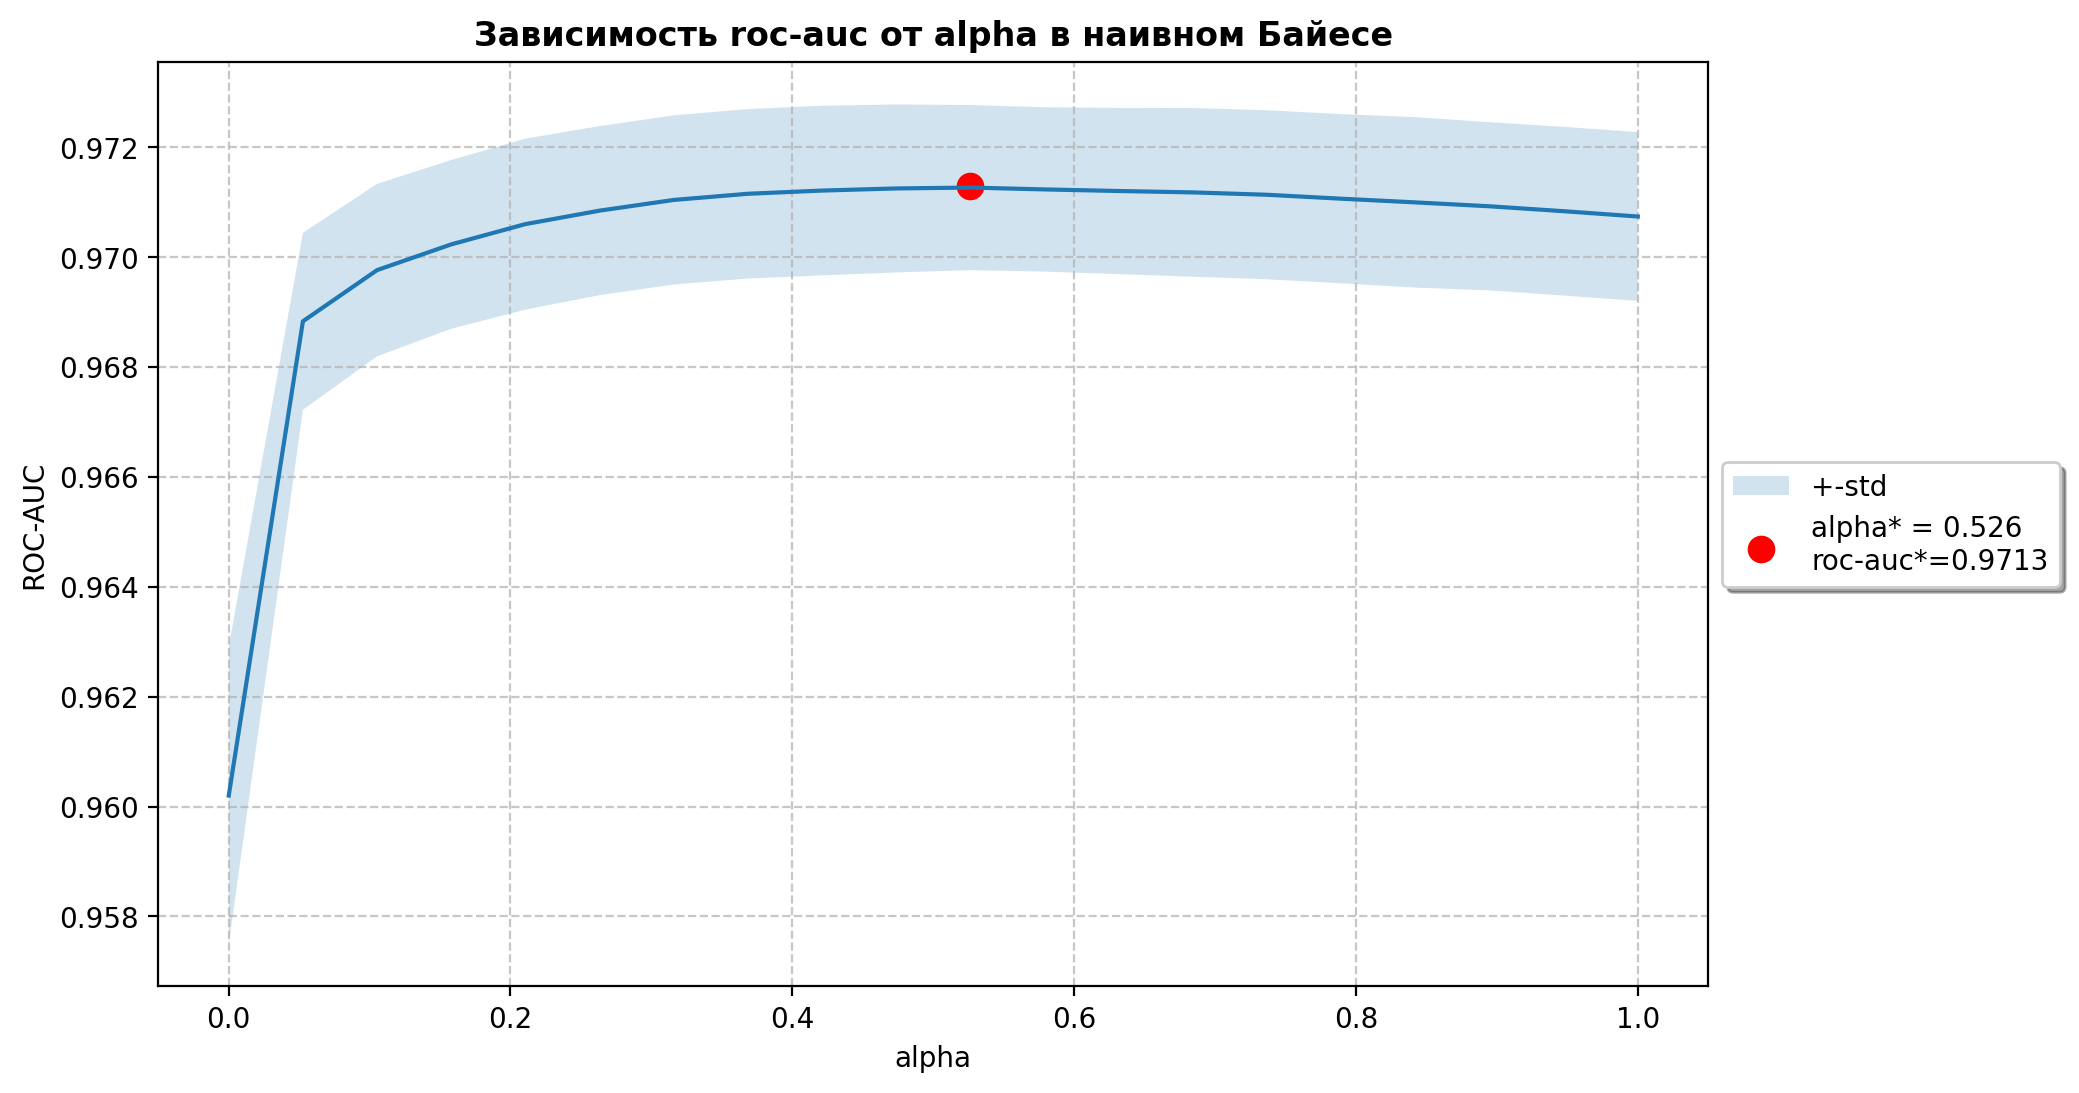

In [17]:
mean_roc_aucs = grid_search_4.cv_results_['mean_test_score']
stds = grid_search_4.cv_results_['std_test_score']

fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(np.linspace(0.0001, 1, 20), mean_roc_aucs)
plt.fill_between(np.linspace(0.0001, 1, 20), np.array(mean_roc_aucs) - np.array(stds), np.array(mean_roc_aucs) + np.array(stds), alpha=0.2, label='+-std')

argmax = np.linspace(0.0001, 1, 20)[np.argmax(mean_roc_aucs)].round(3)
max = np.max(mean_roc_aucs).round(4)

plt.scatter(argmax, max, color='red', s=80, label=f'alpha* = {argmax}\nroc-auc*={max}')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), frameon=True, shadow=True)
plt.xlabel('alpha')
plt.ylabel('ROC-AUC')
plt.grid(alpha=0.7, linestyle='--')
plt.title('Зависимость roc-auc от alpha в наивном Байесе', weight='bold')

plt.show()

Хорошие и стабильные результаты! Однако до логрега не дотягивают. Попробуем эту же модель на CountVectorizer-е:

In [ ]:
pipeline = Pipeline([
    ('Vectorizer', CountVectorizer(encoding='utf8', max_df=0.9, min_df=0.0005)),
    ('Classifier', MultinomialNB()) 
])

param_grid = {'Classifier__alpha': np.linspace(0.0001, 1, 20)}
grid_search_5 = GridSearchCV(pipeline, param_grid, cv=4, scoring=make_scorer(roc_auc_score, needs_proba=True), verbose=3)
grid_search_5.fit(texts, targets)

In [18]:
mean_roc_aucs = grid_search_5.cv_results_['mean_test_score']
stds = grid_search_5.cv_results_['std_test_score']

fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(np.linspace(0.0001, 1, 20), mean_roc_aucs)
plt.fill_between(np.linspace(0.0001, 1, 20), np.array(mean_roc_aucs) - np.array(stds), np.array(mean_roc_aucs) + np.array(stds), alpha=0.2, label='+-std')

argmax = np.linspace(0.0001, 1, 20)[np.argmax(mean_roc_aucs)].round(3)
max = np.max(mean_roc_aucs).round(4)

plt.scatter(argmax, max, color='red', s=80, label=f'alpha* = {argmax}\nroc-auc*={max}')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), frameon=True, shadow=True)
plt.xlabel('alpha')
plt.ylabel('ROC-AUC')
plt.grid(alpha=0.7, linestyle='--')
plt.title('Зависимость roc-auc от alpha в наивном Байесе', weight='bold')

plt.show()

Тоже хороший и стабильный результат, но не лучший.

### Бустинг

Попробуем и бустинг - возьму LightGBM. Предварительно с помощью оптюны подберём параметры.

In [15]:
X_train, X_val, y_train, y_val = train_test_split(texts, targets, test_size=0.2)

#преобразуем в TF-IDF
vectorizer = TfidfVectorizer(encoding='utf8', max_df=0.9, min_df=0.0005)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

In [16]:
#подберём параметры с помощью optuna
start_time = time.time()

def objective(trial):
    params= {
        "objective": "binary",
        "verbosity": -1,
        "max_depth": trial.suggest_int("max_depth", 2, 16),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0), 
        "random_state": 42
    }

    clf = LGBMClassifier(**params)
    clf.fit(
        X=X_train_tfidf,
        y=y_train
    )
    preds = clf.predict_proba(X_val_tfidf)[:, 1]
    auc_valid = roc_auc_score(
        y_true=y_val,
        y_score=preds
    )

    #прунер, чтобы делать early_stopping для конкретного trial-а
    trial.report(auc_valid, trial.number)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return auc_valid

#чтобы не выводился мусор, напишем кастомный коллбэк
logger = logging.getLogger(optuna.__name__)
logger.setLevel(logging.ERROR)

def custom_callback(study, trial, logging_frequency=5):
    best_trial = study.best_trial
    elapsed_time = time.time() - start_time
    if trial.number % logging_frequency == 0:
        print(f"Попытка {trial.number} закончена со значением: {np.round(trial.value, 5)}, лучшая попытка {best_trial.number} со значением {np.round(best_trial.value, 5)}, с начала поиска прошло {int(elapsed_time)} секунд")

#чтобы была возможность сделать early stopping всего study, ещё один кастомный коллбэк
def early_stopping_callback(study, trial, early_stopping_rounds=10):
    num_trials = early_stopping_rounds
    if len(study.trials) >= num_trials:
        last_values = [tr.value for tr in study.trials[-num_trials:]]

        if last_values == sorted(last_values, reverse=True):
            print(f'Производительность не улучшалась последние {num_trials} испытаний.')
            study.stop()

study = optuna.create_study(direction='maximize', pruner=MedianPruner(n_warmup_steps=10))
%time study.optimize(objective, n_trials=120, callbacks=[early_stopping_callback, custom_callback])

Попытка 0 закончена со значением: 0.96818, лучшая попытка 0 со значением 0.96818, с начала поиска прошло 2 секунд
Попытка 5 закончена со значением: 0.97262, лучшая попытка 5 со значением 0.97262, с начала поиска прошло 13 секунд
Попытка 10 закончена со значением: 0.9593, лучшая попытка 5 со значением 0.97262, с начала поиска прошло 26 секунд
Попытка 15 закончена со значением: 0.96897, лучшая попытка 14 со значением 0.97389, с начала поиска прошло 40 секунд
Попытка 20 закончена со значением: 0.96991, лучшая попытка 14 со значением 0.97389, с начала поиска прошло 54 секунд
Попытка 25 закончена со значением: 0.97221, лучшая попытка 14 со значением 0.97389, с начала поиска прошло 70 секунд
Попытка 30 закончена со значением: 0.9723, лучшая попытка 14 со значением 0.97389, с начала поиска прошло 84 секунд
Попытка 35 закончена со значением: 0.96499, лучшая попытка 32 со значением 0.97535, с начала поиска прошло 100 секунд
Попытка 40 закончена со значением: 0.97144, лучшая попытка 32 со значен

In [17]:
print(study.best_params, '\n')
print(f'Best roc-auc: {study.best_value}')

{'max_depth': 16, 'learning_rate': 0.20442100089462736, 'n_estimators': 242, 'num_leaves': 196, 'reg_alpha': 0.026806682761096268, 'reg_lambda': 0.0006299119170691814} 

Best roc-auc: 0.9762092981773366


Качество отличное, почти как у логрега, так что эту модель тоже берём на заметку.

### LSTM

Подготовим данные для LSTM-ки по следующей схеме:
1. Индексируем все слова из нашего корпуса - просто кладём их в словарь с уникальными значениями
2. Токенизируем предложения и делаем паддинг к длине самого длинного сообщения, чтобы все сообщения имели одинаковую длину (171)
3. Загружаем предобученные эмбеддинги из glove
4. Делим западдингованные предложения на трейн и валидацию и обучаем на трейне LSTM + голову + дообучем паддинги.

In [19]:
### делаем словарь токенов
tokenized_texts = [word_tokenize(text) for text in texts]
vocab = defaultdict(lambda: len(vocab) + 1)
sequences_from_texts = [[vocab[word] for word in text] for text in tokenized_texts]
vocab_length = len(vocab) + 1  # +1 для паддинга

### применим паддинг к нашим последовательностям
max_len = np.max([len(sequence) for sequence in sequences_from_texts])
padded_sequences = np.zeros((len(sequences_from_texts), max_len)) #паддинг нулями

for i, seq in enumerate(sequences_from_texts):
    padded_sequences[i, :len(seq)] = seq
padded_sequences = padded_sequences.astype(int)

### делаем словарь эмбеддингов
embed_dim = 100
embed_matrix = np.zeros((vocab_length, embed_dim))
embed_dict = {}

with open('/kaggle/input/glove-embeddings-local/glove.6B.100d.txt', 'r', encoding='utf-8') as file:
    for line in file:
        data = line.split()
        word = data[0]
        vector = np.asarray(data[1:])
        embed_dict[word] = vector
        
### сопоставляем эмбеддинги с индексами слов в vocab
for word, index in vocab.items():
    vector = embed_dict.get(word)
    if vector is not None:
        embed_matrix[index] = vector
        
vocab = dict(vocab)

In [21]:
#разделим трейн на валидацию и трейн для lstm-ки
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, 
    train['target'], 
    test_size=0.2
)

И теперь сама модель: на двунаправленную и двуслойную LSTM, которая будет работать с GloVe эмбеддингами, мы навесим голову из пары полносвязных слоёв. Между ними, естественно, вставим дропаут и батч нормализацию, и получим классификатор, который должен нам оценивать вероятности.

In [22]:
class LSTM_classifier(nn.Module):
    def __init__(self, embedding_matrix, max_length):
        super(LSTM_classifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix), freeze=False, padding_idx=0) #можем дообучать эмбеддинги
        self.lstm = nn.LSTM(input_size=100, hidden_size=171, batch_first=True, bidirectional=True, dropout=0.2, num_layers=2)
        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.batch_norm = nn.BatchNorm1d(2 * max_length)
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(2 * max_length, max_length)
        self.dense2 = nn.Linear(max_length, max_length)
        self.output = nn.Linear(max_length, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x.to(torch.float32))
        x = x.permute(0, 2, 1)
        x = self.pooling(x).squeeze(-1)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = torch.relu(self.dense1(x))
        x = self.dropout(x)
        x = torch.relu(self.dense2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.output(x))
        return x

In [23]:
input_dim = embed_matrix.shape[0]
output_dim = embed_matrix.shape[1]

#делаем даталоудеры
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train.values, dtype=torch.float32))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(y_val.values, dtype=torch.float32))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

#активируем гпу
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTM_classifier(embed_matrix, int(max_len)).to(device) #переносим модельку на GPU
optimizer = RMSprop(model.parameters(), lr=0.001)
criterion = nn.BCELoss() #кросс-энтропия
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True, min_lr=0.001)

#данных мало, поэтому берём всего 3 эпохи, чтобы не оверфитнуться
num_epochs = 3
model.train()
#тренируемся
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            val_loss += criterion(outputs, targets.view(-1, 1)).item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)
    model.train()

    print(f'Epoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss}')

Epoch 1, Train Loss: 0.08938230574131012, Val Loss: 0.25383738956103724
Epoch 2, Train Loss: 0.486612468957901, Val Loss: 0.4569296009254222
Epoch 3, Train Loss: 0.021495120599865913, Val Loss: 0.30021827894390796


Теперь проверим, какой roc-auc выдаёт наша модель на валидации:

In [28]:
model.eval()
predictions = []
true_labels = []

#достаём предсказания
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        predictions.extend(output.squeeze().cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)

roc_auc = roc_auc_score(true_labels, predictions)
print(f"ROC AUC Score: {roc_auc}")
print(f'Accuracy: {accuracy_score(true_labels, predictions >= 0.5)}')
print(f'F1 score: {f1_score(true_labels, predictions >= 0.5)}')

ROC AUC Score: 0.9819544160215475
Accuracy: 0.9078624078624079
F1 score: 0.9381953028430161


Результаты на валидации аж 0.98! Это супер, но и сил больше всего ушло как раз на неё.

## Сравнение лучших кандидатов

По итогу рассмотрения всех моделей у нас есть три главных кандидата - это 
1. Классификатор на основе LSTM и glove эмбеддингов 
2. Логистическая регрессия на TF-IDF представлениях текстов
3. Бустинг от майкрософт

Возьмём эти классификаторы, обучим их на одной и той же выборке и сравним результаты по калибровочным кривым, PR-ROC, AUC-ROC, F1-score и распределению вероятностей ответов. Выберем наиболее уверенную и робастную модель.

### Логрег на TF-IDF

In [35]:
X_train, X_val, y_train, y_val = train_test_split(train['clean_text'], train['target'], test_size=0.2)

### заводим оптимальный логрег
c_optimal = np.logspace(-1, 2.7, 20)[np.argmax(grid_search_1.cv_results_['mean_test_score'])]
logreg = Pipeline(
    [
        ('Vectorizer', TfidfVectorizer(encoding='utf8', max_df=0.9, min_df=0.0005)),
        ('LogReg', LogisticRegression(C=c_optimal, max_iter=10000))
    ]
)
logreg.fit(X_train, y_train)
preds_logreg = logreg.predict_proba(X_val)[:, 1]

### LGBM

In [38]:
### заводим оптимальный бустинг
boosting = Pipeline(
    [
        ('Vectorizer', TfidfVectorizer(encoding='utf8', max_df=0.9, min_df=0.0005)),
        ('Boosting', LGBMClassifier(objective='binary', verbosity=-1, **study.best_params))
    ]
)
boosting.fit(X_train, y_train)
preds_boosting = boosting.predict_proba(X_val)[:, 1]

### LSTM

In [39]:
### заводим LSTM
### обрабатываем трейн
tokenized_train = [word_tokenize(text) for text in X_train]
sequences_from_train = [[vocab.get(word, 0) for word in text] for text in tokenized_train]
padded_train = np.zeros((len(sequences_from_train), max_len))

for i, seq in enumerate(sequences_from_train):
    padded_train[i, :len(seq)] = seq
padded_train = padded_train.astype(int)

### обрабатываем вал
tokenized_val = [word_tokenize(text) for text in X_val]
sequences_from_val = [[vocab.get(word, 0) for word in text] for text in tokenized_val]
padded_val = np.zeros((len(sequences_from_val), max_len))

for i, seq in enumerate(sequences_from_val):
    padded_val[i, :len(seq)] = seq
padded_val = padded_val.astype(int)

### тренируем сетку
### делаем даталоудеры
train_data = TensorDataset(torch.tensor(padded_train, dtype=torch.long), torch.tensor(y_train.values, dtype=torch.float32))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

model = LSTM_classifier(embed_matrix, int(max_len)).to(device) #переносим модельку на GPU
optimizer = RMSprop(model.parameters(), lr=0.001)
criterion = nn.BCELoss() #кросс-энтропия
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True, min_lr=0.001)

num_epochs = 3
model.train()

### тренируемся на трейне
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Train Loss: {loss.item()}')
    

### получим предикты на валидации
model.eval()
preds_lstm = []

val_data = TensorDataset(torch.tensor(padded_val, dtype=torch.long), torch.tensor(y_val.values, dtype=torch.float32))
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds_lstm.extend(outputs.squeeze().cpu().numpy())

preds_lstm = np.array(preds_lstm)

Epoch 1, Train Loss: 0.258450448513031
Epoch 2, Train Loss: 0.12662194669246674
Epoch 3, Train Loss: 0.026171745732426643


### Метрики

Посмотрим на AUC-ROC и AUC-PR кривые для каждой модели и помощью методов из файлика `plotting.py`.

In [ ]:
from plotting import depict_multiple_pr_roc, plot_calibration_curve

LogReg metrics
AUC-PR: 0.99189
AUC-ROC: 0.98203

LGBM metrics
AUC-PR: 0.99190
AUC-ROC: 0.98231

LSTM metrics
AUC-PR: 0.99314
AUC-ROC: 0.98610



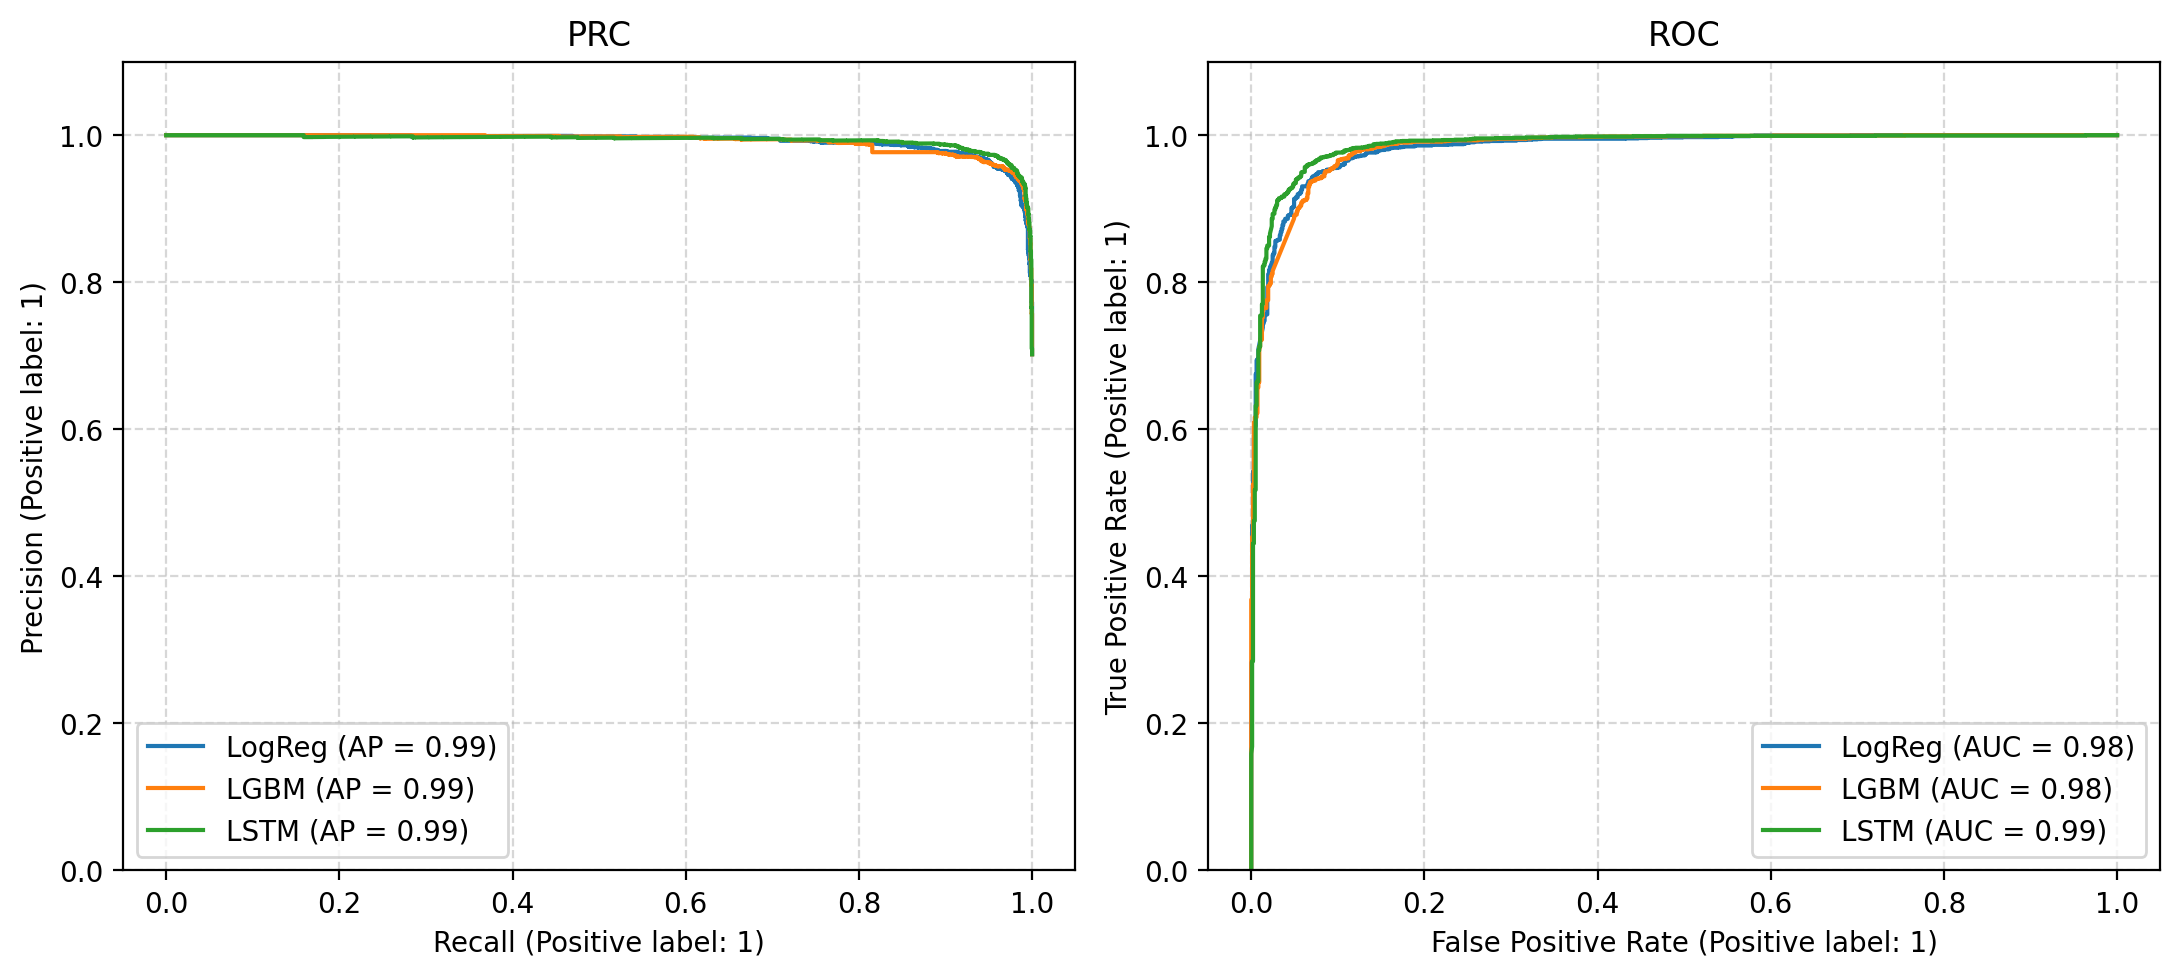

In [54]:
depict_multiple_pr_roc(y_true=y_val, 
                       y_preds=[preds_logreg, preds_boosting, preds_lstm],
                       classifier_names=['LogReg', 'LGBM', 'LSTM'])

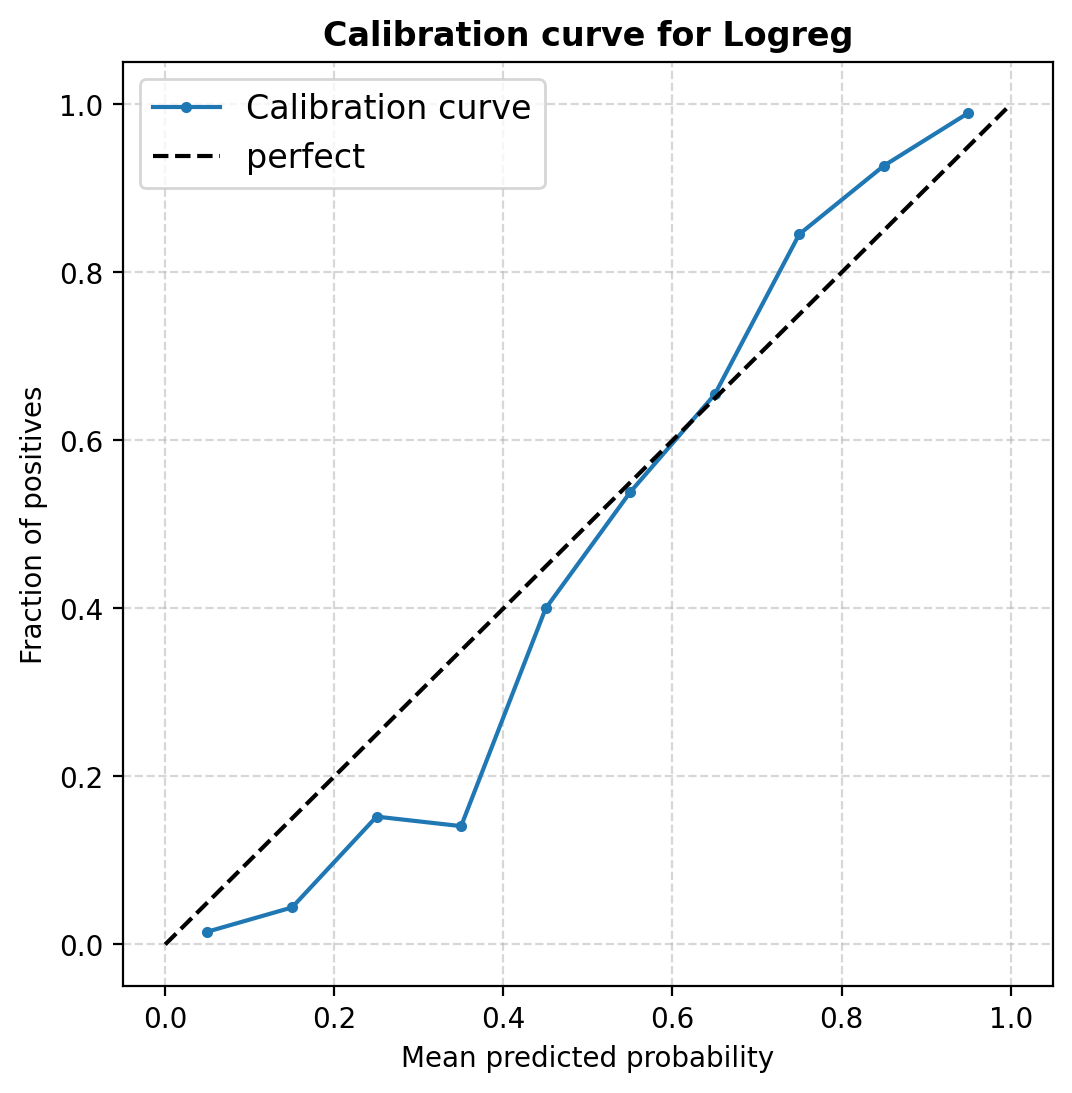

In [60]:
plot_calibration_curve(y_test=y_val, preds=preds_logreg, classifier_name='Logreg')

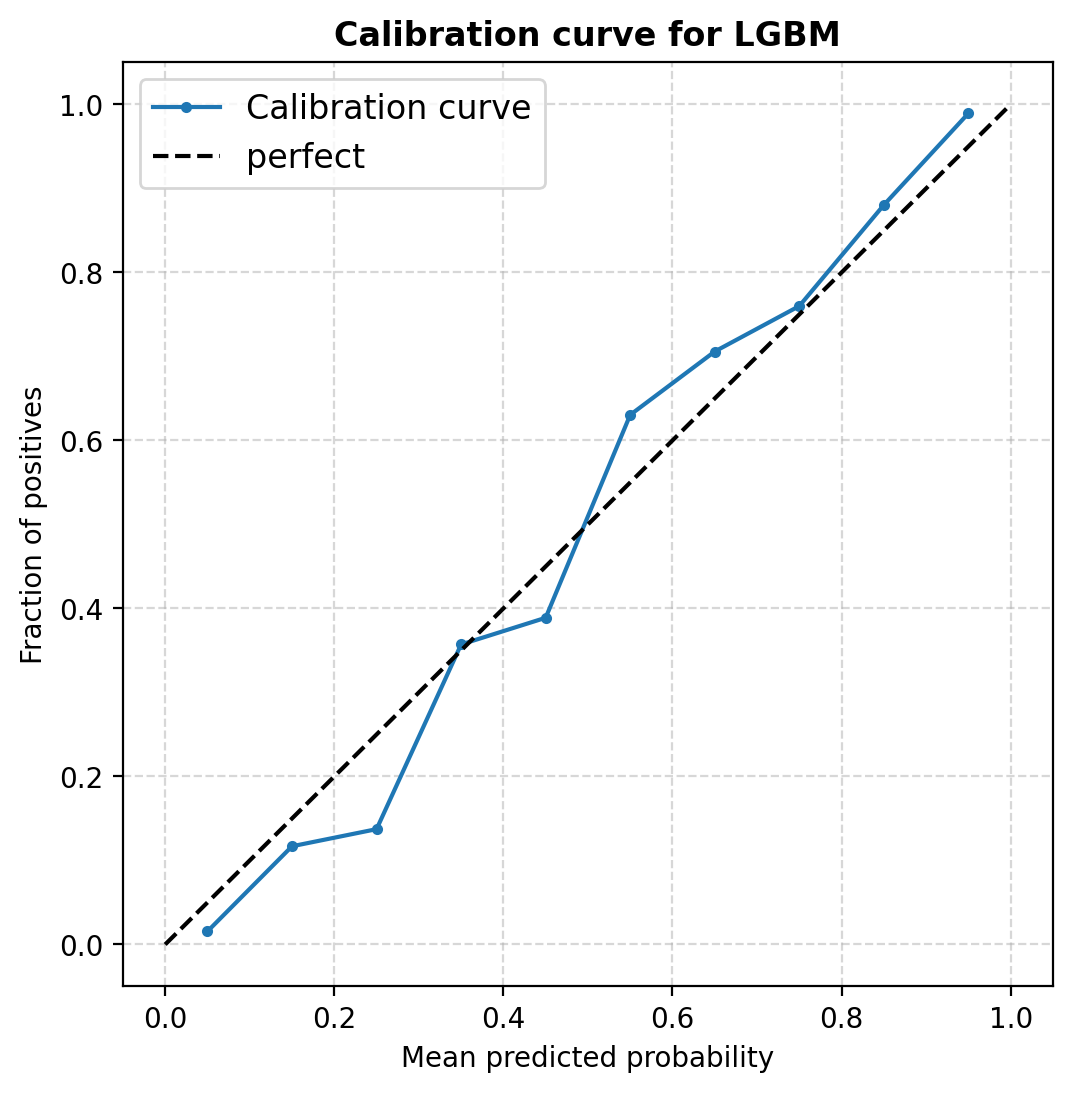

In [61]:
plot_calibration_curve(y_test=y_val, preds=preds_boosting, classifier_name='LGBM')

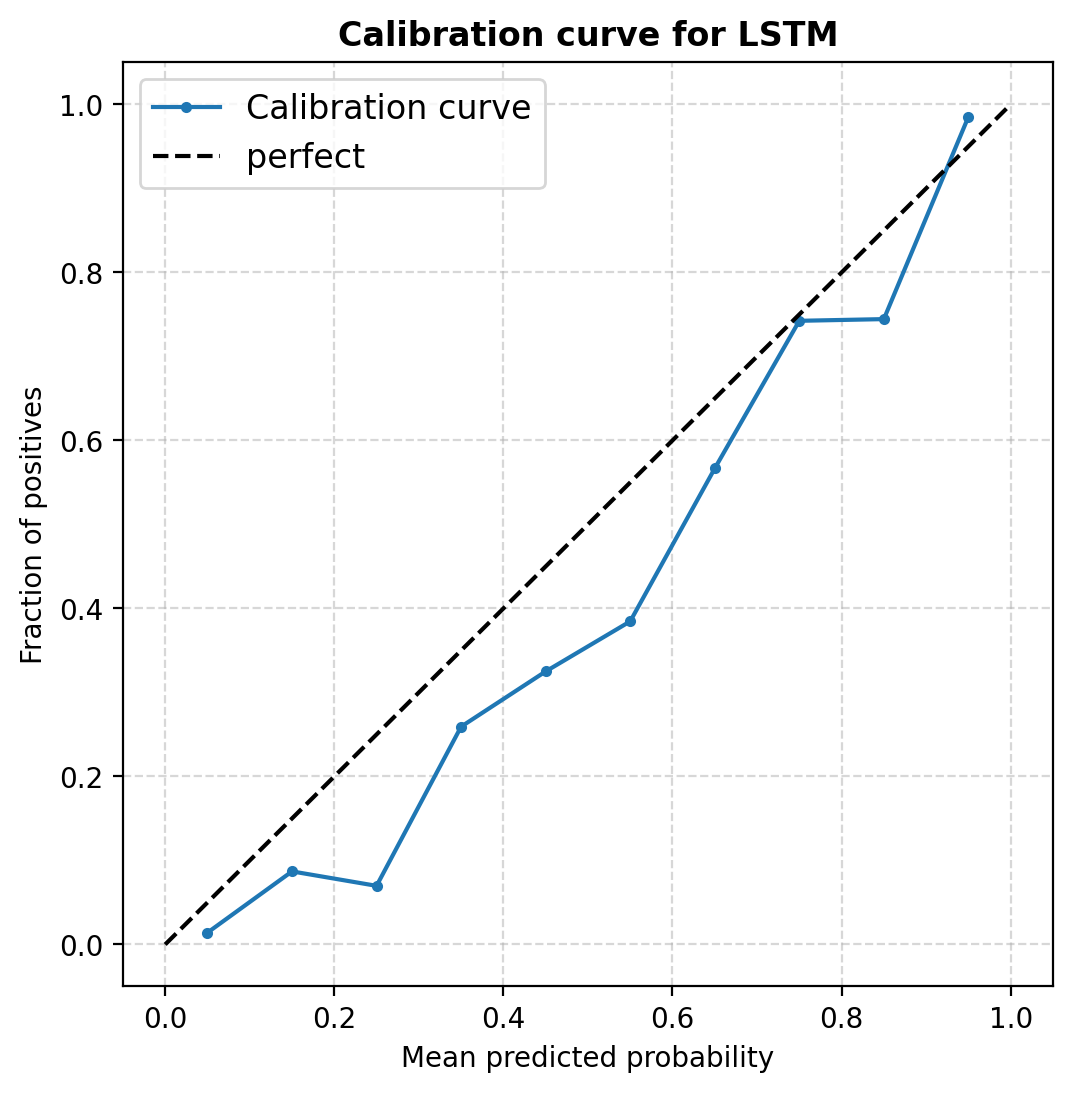

In [62]:
plot_calibration_curve(y_test=y_val, preds=preds_lstm, classifier_name='LSTM')

Калибровочные кривые у всех кандидатов средненькие, лучше всех у LGBM, но он совсем немного уступает нейронке в качестве.

In [65]:
for model, preds in zip(['LogReg', 'LGBM', 'LSTM'], [preds_logreg, preds_boosting, preds_lstm]):
    print(f'F1-score для {model}: {f1_score(y_val, preds >= 0.5)}')

F1-score для LogReg: 0.959602505940808
F1-score для LGBM: 0.9632829373650109
F1-score для LSTM: 0.9660361134995701


По всем показателям пока что впереди LSTM, но калиборовочная кривая у неё не очень. Посмотрим на распределения предсказанных вероятностей для всех моделей

In [72]:
plt.figure(figsize=(12, 6), facecolor='whitesmoke')
sns.kdeplot(preds_logreg, color='blue', label='LogReg', fill=True, alpha=0.1)
sns.kdeplot(preds_lstm, color='red', label='LSTM', fill=True, alpha=0.1)
sns.kdeplot(preds_boosting, color='green', label='LGBM', fill=True, alpha=0.1)
plt.title('Распределение предсказанных вероятностей', weight='bold')
plt.legend()
plt.grid(alpha=0.5, linestyle='--')
plt.show()

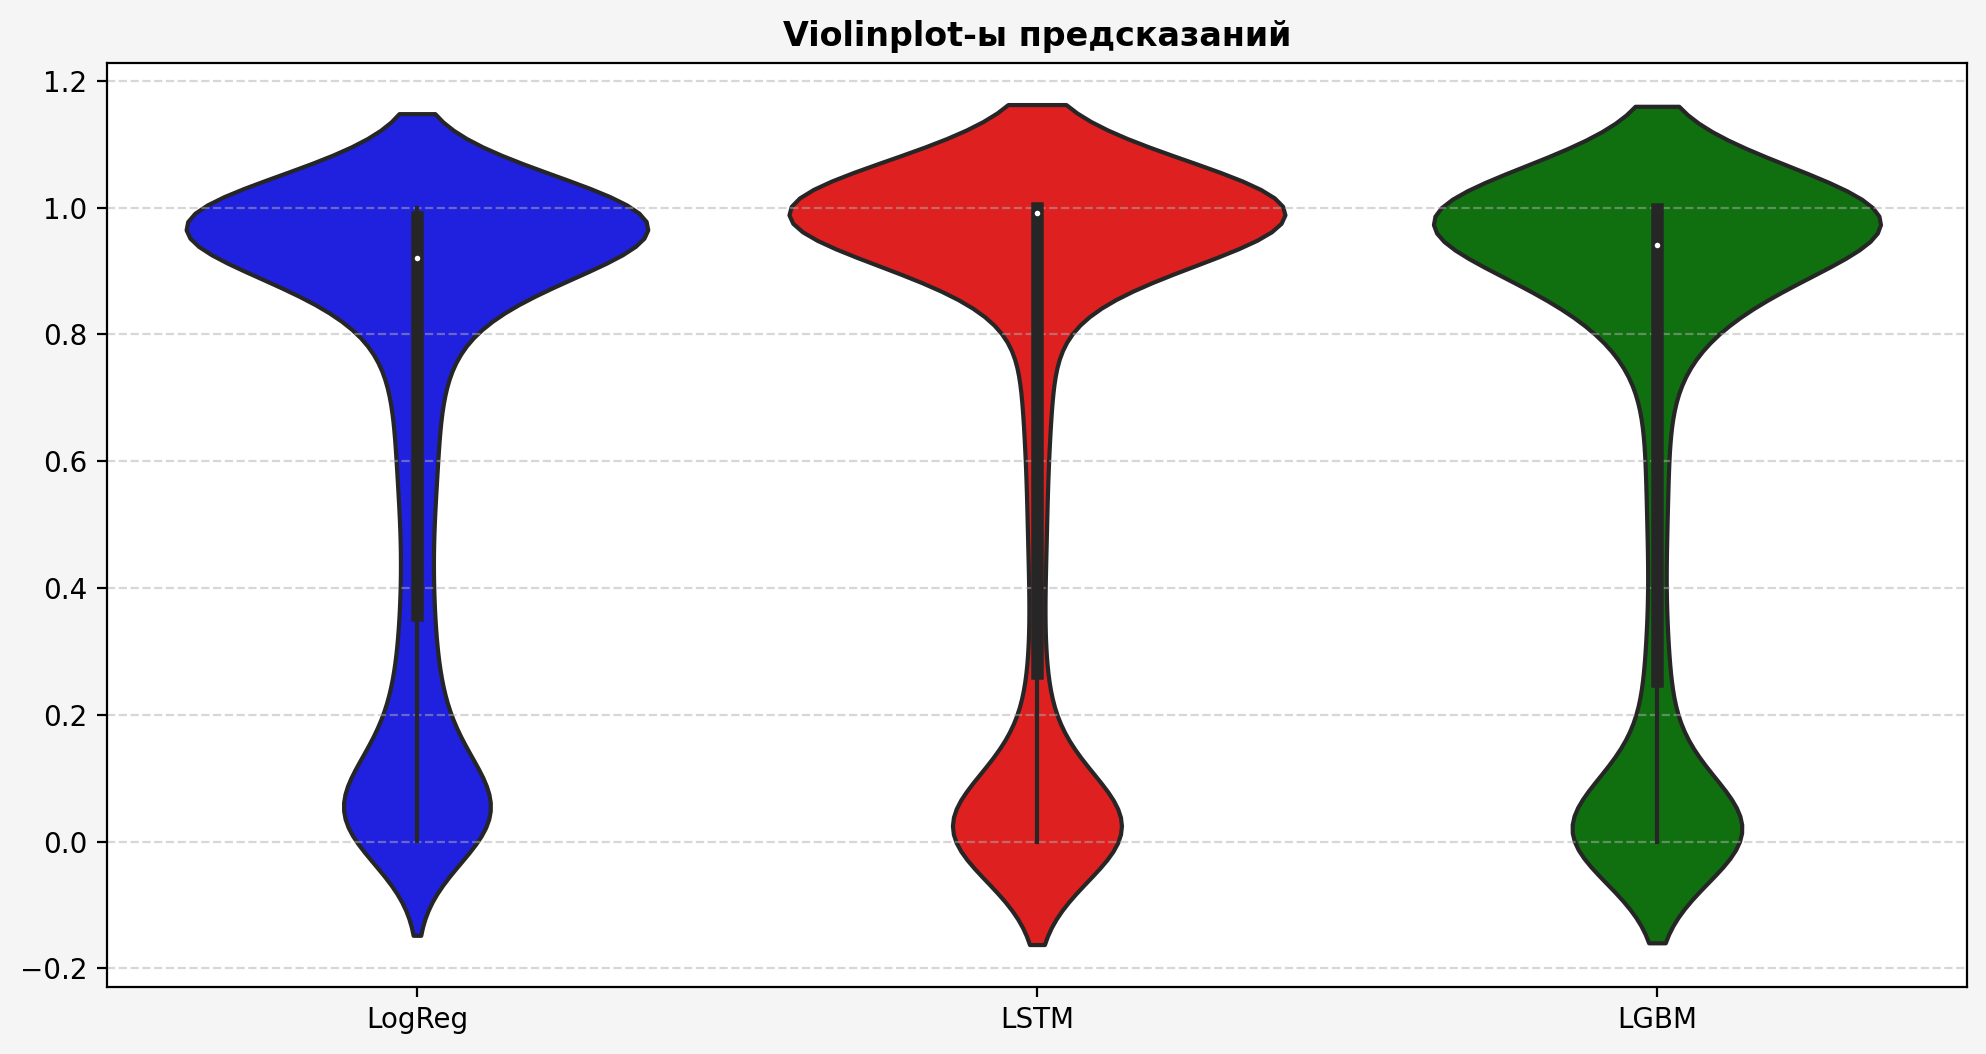

In [77]:
plt.figure(figsize=(12, 6), facecolor='whitesmoke')
sns.violinplot(data=[preds_logreg, preds_lstm, preds_boosting], palette=['blue', 'red', 'green'])
plt.xticks([0, 1, 2], ['LogReg', 'LSTM', 'LGBM'])
plt.title('Violinplot-ы предсказаний', weight='bold')
plt.grid(alpha=0.5, linestyle='--', axis='y')
plt.show()

LSTM всё же наиболее уверенно выписывает вероятности, среди её скоров мало неуверенных (находящихся в районе 0.5), поэтому в качестве финальной модели возьмём её.

## Предсказания на тесте

### LSTM

In [80]:
#всё то же самое для теста
test_texts = test['clean_text']
tokenized_test = [word_tokenize(text) for text in test_texts]
sequences_from_test = [[vocab.get(word, 0) for word in text] for text in tokenized_test]

padded_test = np.zeros((len(sequences_from_test), max_len))
for i, seq in enumerate(sequences_from_test):
    padded_test[i, :len(seq)] = seq
    
padded_test = padded_test.astype(int)

Теперь обучимся на полном трейне и затем получим предсказания вероятностей на тесте

In [81]:
padded_train = padded_sequences

#делаем даталоудеры
train_data = TensorDataset(torch.tensor(padded_train, dtype=torch.long), torch.tensor(train['target'].values, dtype=torch.float32))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

model = LSTM_classifier(embed_matrix, int(max_len)).to(device) #переносим модельку на GPU
optimizer = RMSprop(model.parameters(), lr=0.001)
criterion = nn.BCELoss() #кросс-энтропия
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True, min_lr=0.001)

num_epochs = 3
model.train()

#тренируемся на полном трейне
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Train Loss: {loss.item()}')

Epoch 1, Train Loss: 0.3762139081954956
Epoch 2, Train Loss: 0.02115722745656967
Epoch 3, Train Loss: 0.029470041394233704


In [82]:
model.eval()
predictions_lstm = []

test_data = TensorDataset(torch.tensor(padded_test, dtype=torch.long))
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

with torch.no_grad():
    for input in test_loader:
        input = input[0].to(device)
        output = model(input)
        predictions_lstm.extend(output.squeeze().cpu().numpy())

predictions_lstm = np.array(predictions_lstm)

Сохраним теперь наши ответы в файлик и закончим на этом :)

In [122]:
final = pd.DataFrame({
    'score': predictions_lstm,
    'text': test['text']
})
final.to_csv('predictions_lstm.csv', index=False)